# Wrangle And Analyze Data

**Author:** Ken Norton (ken@kennethnorton.com)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Wrangle-And-Analyze-Data" data-toc-modified-id="Wrangle-And-Analyze-Data-1">Wrangle And Analyze Data</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Gather" data-toc-modified-id="Gather-1.2">Gather</a></span></li><li><span><a href="#Assess" data-toc-modified-id="Assess-1.3">Assess</a></span></li><li><span><a href="#Clean" data-toc-modified-id="Clean-1.4">Clean</a></span><ul class="toc-item"><li><span><a href="#Quality-Issue:-Change-indexes" data-toc-modified-id="Quality-Issue:-Change-indexes-1.4.1">Quality Issue: Change indexes</a></span></li><li><span><a href="#Tidyness-Issue:-Merge-the-three-different-datasets-into-one-dataframe" data-toc-modified-id="Tidyness-Issue:-Merge-the-three-different-datasets-into-one-dataframe-1.4.2">Tidyness Issue: Merge the three different datasets into one dataframe</a></span></li><li><span><a href="#Quality-Issue:-Remove-empty-and-unneeded-columns" data-toc-modified-id="Quality-Issue:-Remove-empty-and-unneeded-columns-1.4.3">Quality Issue: Remove empty and unneeded columns</a></span></li><li><span><a href="#Quality-Issue:-Correct-data-types" data-toc-modified-id="Quality-Issue:-Correct-data-types-1.4.4">Quality Issue: Correct data types</a></span></li><li><span><a href="#Quality-Issue:-Make-sure-all-tweets-have-images-and-ratings" data-toc-modified-id="Quality-Issue:-Make-sure-all-tweets-have-images-and-ratings-1.4.5">Quality Issue: Make sure all tweets have images and ratings</a></span></li><li><span><a href="#Quality-Issue:-Doggie-stage-columns-are-spread-across-four-columns-and-not-normalized" data-toc-modified-id="Quality-Issue:-Doggie-stage-columns-are-spread-across-four-columns-and-not-normalized-1.4.6">Quality Issue: Doggie stage columns are spread across four columns and not normalized</a></span></li><li><span><a href="#Quality-Issue:-Add-numeric-rating-column" data-toc-modified-id="Quality-Issue:-Add-numeric-rating-column-1.4.7">Quality Issue: Add numeric rating column</a></span></li><li><span><a href="#Quality-Issue:-Image-prediction-breeds-have-inconsistent-casing" data-toc-modified-id="Quality-Issue:-Image-prediction-breeds-have-inconsistent-casing-1.4.8">Quality Issue: Image prediction breeds have inconsistent casing</a></span></li><li><span><a href="#Quality-Issue:-Image-predictions-are-spread-across-three-columns-and-should-be-in-a-single-column" data-toc-modified-id="Quality-Issue:-Image-predictions-are-spread-across-three-columns-and-should-be-in-a-single-column-1.4.9">Quality Issue: Image predictions are spread across three columns and should be in a single column</a></span></li><li><span><a href="#Tidyness-Issue:-Make-a-new-&quot;social-total&quot;-column" data-toc-modified-id="Tidyness-Issue:-Make-a-new-&quot;social-total&quot;-column-1.4.10">Tidyness Issue: Make a new "social total" column</a></span></li></ul></li><li><span><a href="#Save-cleaned-data" data-toc-modified-id="Save-cleaned-data-1.5">Save cleaned data</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.6">Analysis</a></span><ul class="toc-item"><li><span><a href="#Question:-Has-WeRateDogs'-popularity-(social-feedback)-changed-over-time?" data-toc-modified-id="Question:-Has-WeRateDogs'-popularity-(social-feedback)-changed-over-time?-1.6.1">Question: Has WeRateDogs' popularity (social feedback) changed over time?</a></span></li><li><span><a href="#Question:-Do-certain-dog-breeds-get-higher-ratings?" data-toc-modified-id="Question:-Do-certain-dog-breeds-get-higher-ratings?-1.6.2">Question: Do certain dog breeds get higher ratings?</a></span></li><li><span><a href="#Question:-Do-certain-dog-breeds-get-more-social-feedback?" data-toc-modified-id="Question:-Do-certain-dog-breeds-get-more-social-feedback?-1.6.3">Question: Do certain dog breeds get more social feedback?</a></span></li><li><span><a href="#Question:-Which-individual-dogs-have-received-the-most-social-feedback?" data-toc-modified-id="Question:-Which-individual-dogs-have-received-the-most-social-feedback?-1.6.4">Question: Which individual dogs have received the most social feedback?</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.7">Conclusion</a></span></li></ul></li></ul></div>

## Introduction

An executive summary of my data wrangling and my analysis are available:

* [wrangle_report.html](wrangle_report.html): briefly describes my wrangling efforts (framed as an internal document)
* [act_report.html](act_report.html): communicates the insights and displays the visualization(s) produced from my wrangled data (framed as an external document)

Your goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tweepy

from tweepy import OAuthHandler
from timeit import default_timer as timer
from IPython.display import Image
from IPython.display import display
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Matplotlib styles
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

## Gather

In [3]:
# WeRateDogs twitter archive
df = pd.read_csv('data/twitter-archive-enhanced.csv')

# Image predictions
df_img = pd.read_csv('data/image-predictions.tsv', sep='\t')

In [4]:
'''
# I've commented this out now that I've generated the file,
# it took 30+ minutes to run so no need to do it again!

# Import my Twitter API keys from separate file
%run twitter-api.py

# Use Twitter API to fetch metadata for tweet_ids
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID 
# in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a 
# .txt file
with open('data/tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run 
    # because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

# Extended tweet info from Twitter API
df_tweets = pd.read_json('data/tweet_json.txt', lines=True)

## Assess

Let's start with visual assessment:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
# Visual inspection of tweet archive (I also opened the CSVs in Excel)
df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


Quality observations:
    
* Columns that refer to replies and retweets don't have a lot of data
* The extracted numerator/denominator columns don't seem to be very accurate

In [7]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [8]:
# Visual inspection of image predictions (I also opened the CSVs in Excel)
df_img

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


Quality observations:

* `p1* .. p3*` columns don't seem normalized
* The dog breeds predicted have varying letter casing (e.g. 'Rhodesian_ridgeback' - initial uppercase - vs. 'bloodhound' - all lowercase)
* Several of the predictions are not dogs (e.g. I saw 'shopping_cart' and 'box_turtle')
* The confidence of the predictions in `p2*` and `p3*` are not very high, especially when the `p1` prediction is of a dog.

In [9]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2337 non-null datetime64[ns]
display_text_range               2337 non-null object
entities                         2337 non-null object
extended_entities                2065 non-null object
favorite_count                   2337 non-null int64
favorited                        2337 non-null bool
full_text                        2337 non-null object
geo                              0 non-null float64
id                               2337 non-null int64
id_str                           2337 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 n

In [10]:
# Visual inspection of extended tweet metadata (I also opened the CSVs in Excel)
df_tweets

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",37511,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,NaN,NaN,8182,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",32240,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,NaN,NaN,6053,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",24293,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,NaN,NaN,4004,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",40854,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,NaN,NaN,8324,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",39059,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,NaN,NaN,9032,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",19628,False,Here we have a majestic great white breaching ...,NaN,...,NaN,NaN,NaN,NaN,2997,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",11468,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,NaN,NaN,NaN,NaN,1984,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",63301,False,When you watch your owner call another dog a g...,NaN,...,NaN,NaN,NaN,NaN,18175,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",27000,False,This is Zoey. She doesn't want to be one of th...,NaN,...,NaN,NaN,NaN,NaN,4118,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",30922,False,This is Cassie. She is a college pup. Studying...,NaN,...,NaN,NaN,NaN,NaN,7108,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


Quality observations:

A [data dictionary](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html) is available on Twitter's developer website.

* The `contributors`, `coordinates`, and `geo` have missing data (and `place` only has 1 value)
* Columns that refer to replies and retweets are also sparse
* Some columns contain JSON data (e.g. `entities`)
* After reviewing Twitter's documentation, there are several other columns we don't care about in our analysis:
  * `id_str`: string representation of the id
  * `truncated`: whether the tweet was truncated (almost always false)
  * `possibly_sensitive`: url might have sensitive content (almost always false)
  * `possibly_sensitive_appealable`: url might have sensitive content (almost always false)
  * `display_text_range`: helps Twitter clients handle extended tweet lengths
  * `favorited`: whether the tweet was favorited by the authenticated user (me) - not to be confused with `favorite_count` (how many times it was favorited by all users)
  * `retweeted`: whether the tweet was RT'd by the authenticated user (me) - not to be confused with `retweet_count` (how many times it was RT'd by all users)
  * `entities` and `extended_entities`: these are JSON values containing extended information about media connected with the tweet. I'm not going to analyze them so I won't be needing them.

Now let's do some programmatic assessment:

In [11]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
df_img.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [13]:
df_tweets.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2337.000000,0.0,2.337000e+03,2.337000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,2203.0,2203.0,2.600000e+01,2.600000e+01,2337.000000
mean,NaN,NaN,7837.055627,NaN,7.420692e+17,7.420692e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,0.0,0.0,8.113972e+17,8.113972e+17,2875.462131
std,NaN,NaN,12147.185494,NaN,6.824243e+16,6.824243e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,0.0,0.0,6.295843e+16,6.295843e+16,4857.524783
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,6.721083e+17,6.721083e+17,1.000000
25%,NaN,NaN,1360.000000,NaN,6.783345e+17,6.783345e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,0.0,0.0,7.761338e+17,7.761338e+17,579.000000
50%,NaN,NaN,3417.000000,NaN,7.185406e+17,7.185406e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.281173e+17,8.281173e+17,1344.000000
75%,NaN,NaN,9597.000000,NaN,7.986825e+17,7.986825e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.637581e+17,8.637581e+17,3352.000000
max,NaN,NaN,162019.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,82408.000000


In [14]:
# Check for duplicate rows
print(df['tweet_id'].duplicated().any())
print(df_img['tweet_id'].duplicated().any())
print(df_tweets['id'].duplicated().any())

False
False
False


## Clean


The requirements of this project are to assess and clean **at least 8 quality issues** and **at least 2 tidiness issues** in this dataset.

I've identified the following **quality issues**:

* Indexes on the three different data sets don't match
* Empty and unneeded columns should be eliminated
* Datatypes need to be corrected
* Some tweets don't have images and/or ratings
* The doggie stages are spread across four columns and not normalized
* Ratings are spread between two numerator and denominator columns and should be in a single column, also the existing numerator/denominator values don't appear to be accurate compared to the tweet text
* Image predictions have inconsistent casing (mix of uppercase and lowercase)
* Image predictions are spread across three columns and should be in a single column

And the following **tidyness issues**:

* A single, merged dataframe should be created
* For convenience, I'd like a single column that sums all "social signals" a tweet received from other users (retweets and favorites) 

### Quality Issue: Change indexes

**Define**

All three datasets have metadata about individual tweets. The best index is Twitter's tweet_id. Setting the index to the same value for all three datasets will make merging and combining easier and reduce errors. 

**Code**

In [15]:
# First I'll need to rename df_tweets 'id' to 'tweet_id' 
# to match the other dataframes
df_tweets.rename(columns={"id": "tweet_id"}, inplace=True)

# Now all of the dataframes share a tweet_id column
# so make that the index
df.set_index('tweet_id', inplace=True)
df_img.set_index('tweet_id', inplace=True)
df_tweets.set_index('tweet_id', inplace=True)

**Test**

In [16]:
print(df.index.name)
print(df_img.index.name)
print(df_tweets.index.name)

tweet_id
tweet_id
tweet_id


### Tidyness Issue: Merge the three different datasets into one dataframe

**Define**

Now that they all share an index, it's easy to merge them into one dataframe. The merge process will create some duplicate columns (ones that appear in more than one dataframe) so I'll need to clean that as well.

I'm creating a new dataframe with the combined data called `df_clean`.

**Code**

In [17]:
# Join the image predictions
df_clean = df.join(df_img, how = 'inner')

# Join the extended tweet data
df_clean = df_clean.join(df_tweets, how = 'inner', lsuffix = '_x')

# Now drop the duplicated columns (ending in '_x')
df_clean = df_clean.drop(df_clean.filter(regex='_x').columns, axis=1)

**Test**

In [18]:
df_clean.head()

,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
tweet_id,,,,,,,,,,,,,,,,,,,,,
892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,...,NaN,NaN,NaN,NaN,8182,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,...,NaN,NaN,NaN,NaN,6053,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,...,NaN,NaN,NaN,NaN,4004,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,...,NaN,NaN,NaN,NaN,8324,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,...,NaN,NaN,NaN,NaN,9032,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


### Quality Issue: Remove empty and unneeded columns

**Define**

In the instructions, I noticed "You only want original ratings (no retweets)." Looking at the dataset, I see the `retweeted_status_id` is present only for retweets. That's the best way to detect and ultimate eliminate rows that refer to retweets.

**Code**

In [19]:
df_clean.retweeted_status_id.nunique()

75

In [20]:
# Remove any row where there's a value in 
# retweeted_status_id (it's a retweet)
df_clean = df_clean.query('retweeted_status_id == "NaN"')

In [21]:
df_clean.retweeted_status_id.unique()

array([nan])

In [22]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 892420643555336193 to 666020888022790149
Data columns (total 55 columns):
timestamp                        1990 non-null object
text                             1990 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1990 non-null object
rating_numerator                 1990 non-null int64
rating_denominator               1990 non-null int64
name                             1990 non-null object
doggo                            1990 non-null object
floofer                          1990 non-null object
pupper                           1990 non-null object
puppo                            1990 non-null object
jpg_url                          1990 non-null object
img_num                          1990 non-null int64
p1                               1990 non-null object
p1_conf 

I still have a lot of columns! Earlier I noticed several that I'm not going to be using in my analysis or aren't relevant. I'm going to drop them so our dataframe stays nice and lean.

In [23]:
# We can drop the columns that are only relevant
# for retweets and replies
df_clean = df_clean.drop(df_clean.filter(regex='retweeted_status').columns,
                         axis=1)
df_clean = df_clean.drop(df_clean.filter(regex='in_reply_to_').columns, axis=1)
df_clean = df_clean.drop(df_clean.filter(regex='quoted_status').columns,
                         axis=1)

# Let's also drop the other unused columns that we
# found above
df_clean.drop([
    'contributors', 'coordinates', 'display_text_range', 'geo', 'place',
    'id_str', 'truncated', 'possibly_sensitive',
    'possibly_sensitive_appealable', 'favorited', 'retweeted', 'entities',
    'extended_entities', 'is_quote_status'
],
              axis=1,
              inplace=True)

**Test**

In [24]:
df_clean.dtypes

timestamp                     object
text                          object
expanded_urls                 object
rating_numerator               int64
rating_denominator             int64
name                          object
doggo                         object
floofer                       object
pupper                        object
puppo                         object
jpg_url                       object
img_num                        int64
p1                            object
p1_conf                      float64
p1_dog                          bool
p2                            object
p2_conf                      float64
p2_dog                          bool
p3                            object
p3_conf                      float64
p3_dog                          bool
created_at            datetime64[ns]
favorite_count                 int64
full_text                     object
lang                          object
retweet_count                  int64
source                        object
u

### Quality Issue: Correct data types

**Define**

I noticed that the `timestamp` column is treated as a string but should be a Python datetime value. I'm planning to do some analysis by date, so I'll need to correct that.

**Code**

In [25]:
# Timestamp should be a datetime
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

**Test**

In [26]:
df_clean.timestamp.dtype

datetime64[ns, UTC]

### Quality Issue: Make sure all tweets have images and ratings

**Define**

Per the instructions, "You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets."

**Code**

I dropped all of the columns related to retweets above.

**Test**

In [27]:
# Are there any rows without an image?
df_clean.jpg_url.isna().sum()

0

In [28]:
# Are there any rows where the rating denominator is missing?
df_clean.rating_denominator.isna().sum()

0

In [29]:
# Are there any rows where the rating denominator is 0?
# I assume some numerators might be 0
df_clean.query('rating_denominator == 0')['rating_denominator'].sum()

0

Good news: all of our rows have both images and ratings, so we've satisfied this requirement.

### Quality Issue: Doggie stage columns are spread across four columns and not normalized

**Define**

WeRateDogs uses four "stages" – doggo, floofer, pupper, and puppo. These columns contain None or their string as a value. We'll need to unify them into one colummn.

**Code**

First I wanted to make sure dogs couldn't be more than one type:

In [30]:
# Testing to see if any tweets are marked doggo and pupper
df_clean.query('doggo == "doggo" and pupper == "pupper"').head()

,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,...,p3,p3_conf,p3_dog,created_at,favorite_count,full_text,lang,retweet_count,source,user
tweet_id,,,,,,,,,,,,,,,,,,,,,
817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None,...,Irish_water_spaniel,0.029769,True,2017-01-07 16:59:28,11249,"This is Dido. She's playing the lead role in ""...",en,2879,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
808106460588765185,2016-12-12 00:29:28+00:00,Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo,None,pupper,None,...,Great_Pyrenees,0.126482,True,2016-12-12 00:29:28,9241,Here we have Burke (pupper) and Dexter (doggo)...,en,2372,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
802265048156610565,2016-11-25 21:37:47+00:00,"Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None,...,Rhodesian_ridgeback,0.012061,True,2016-11-25 21:37:47,6984,"Like doggo, like pupper version 2. Both 11/10 ...",en,1478,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
801115127852503040,2016-11-22 17:28:25+00:00,This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None,...,bluetick,0.021953,True,2016-11-22 17:28:25,8536,This is Bones. He's being haunted by another d...,en,2258,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."
785639753186217984,2016-10-11 00:34:48+00:00,This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,doggo,None,pupper,None,...,echidna,0.005442,False,2016-10-11 00:34:48,8241,This is Pinot. He's a sophisticated doggo. You...,en,2395,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na..."


I see that tweets *can* have more than one dog type, so I'll need to support multiple values per row.

In [31]:
df_clean['doggo'] = df_clean['doggo'].replace('None', '')
df_clean['floofer'] = df_clean['floofer'].replace('None', '')
df_clean['pupper'] = df_clean['pupper'].replace('None', '')
df_clean['puppo'] = df_clean['puppo'].replace('None', '')

df_clean['doggie_stage'] = df_clean.doggo + df_clean.floofer + df_clean.pupper + df_clean.puppo

In [32]:
df_clean['doggie_stage'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

Now I'll need to comma-separate the multiple values.

In [33]:
df_clean['doggie_stage'] = df_clean['doggie_stage'].replace({
    'doggopuppo':
    'doggo,puppo',
    'doggofloofer':
    'doggo,floofer',
    'doggopupper':
    'doggo,pupper'
})

**Test**

In [34]:
df_clean['doggie_stage'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
       'doggo,floofer', 'doggo,pupper'], dtype=object)

In [35]:
df_clean.doggie_stage.value_counts()

                 1684
pupper            203
doggo              63
puppo              22
doggo,pupper        9
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: doggie_stage, dtype: int64

Now that we've verified everything worked correctly, let's drop the older columns that we won't be needing now.

In [36]:
# Let's also drop the old doggie type columns
df_clean.drop(['doggo', 'puppo', 'floofer', 'pupper'],
              axis=1,
              inplace=True)

In [37]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 892420643555336193 to 666020888022790149
Data columns (total 25 columns):
timestamp             1990 non-null datetime64[ns, UTC]
text                  1990 non-null object
expanded_urls         1990 non-null object
rating_numerator      1990 non-null int64
rating_denominator    1990 non-null int64
name                  1990 non-null object
jpg_url               1990 non-null object
img_num               1990 non-null int64
p1                    1990 non-null object
p1_conf               1990 non-null float64
p1_dog                1990 non-null bool
p2                    1990 non-null object
p2_conf               1990 non-null float64
p2_dog                1990 non-null bool
p3                    1990 non-null object
p3_conf               1990 non-null float64
p3_dog                1990 non-null bool
created_at            1990 non-null datetime64[ns]
favorite_count        1990 non-null int64
full_text             1990 non-

### Quality Issue: Add numeric rating column

**Define**

The denominator for WeRateDogs is usually comically larger than the numerator (12/10). I'll make a new numeric column that represents the decimal version of the rating so I can compare them. I noticed in my visual inspection that the numerator/denominator columns have quality issues, so I'll attempt to repopulate them from the tweet text.

**Code**

In [38]:
# Here's an example of a tweet where the rating in the text
# (9.75/10) doesn't match the column ratings (75/10)
with pd.option_context('display.max_colwidth', 280):
    print(df_clean.loc[786709082849828864][[
        'text', 'rating_numerator', 'rating_denominator'
    ]])

text                  This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
rating_numerator                                                                                                                                    75
rating_denominator                                                                                                                                  10
Name: 786709082849828864, dtype: object


In [39]:
df_clean.dtypes

timestamp             datetime64[ns, UTC]
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
jpg_url                            object
img_num                             int64
p1                                 object
p1_conf                           float64
p1_dog                               bool
p2                                 object
p2_conf                           float64
p2_dog                               bool
p3                                 object
p3_conf                           float64
p3_dog                               bool
created_at                 datetime64[ns]
favorite_count                      int64
full_text                          object
lang                               object
retweet_count                       int64
source                             object
user                              

In [40]:
# Use a regex to extract from the tweet text into two new
# columns - nnum (new numerator), and nden (new denominator)
df_clean[['nnum',
          'nden']] = df_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)',
                                               expand=True)

In [41]:
# Convert the columns to int
df_clean['nnum'] = pd.to_numeric(df_clean['nnum'])
df_clean['nden'] = pd.to_numeric(df_clean['nden'])

In [42]:
# Now let's look at any columns where my new denominator doesn't
# agree with rating_denominator
with pd.option_context('display.max_colwidth', 280):
    print(df_clean.loc[~(df_clean['rating_numerator'] == df_clean['nnum'])][[
        'text', 'nnum', 'nden'
    ]])

                                                                                                                                                                                 text  \
tweet_id                                                                                                                                                                                
883482846933004288                           This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948   
786709082849828864                                   This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS   
778027034220126208  This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq   
680494726643068929                                                         

There were four rows, and I've fixed them all!

Now I'm going to drop the old columns, and rename my temporary columns to use `rating_numerator` and `rating_denominator`.

In [43]:
# Drop the old (bad) numerator and denominator columns
df_clean.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

In [44]:
# Now rename my temp columns
df_clean.rename(columns={
    'nnum': 'rating_numerator',
    'nden': 'rating_denominator'
},
                inplace=True)

Since I'm going to be doing a lot of analysis on the ratings, I'm going to create a new column called `rating` that contains a decimal conversion of the fraction columns.

In [45]:
df_clean['rating'] = df_clean['rating_numerator'] / df_clean['rating_denominator']

**Test**

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 892420643555336193 to 666020888022790149
Data columns (total 26 columns):
timestamp             1990 non-null datetime64[ns, UTC]
text                  1990 non-null object
expanded_urls         1990 non-null object
name                  1990 non-null object
jpg_url               1990 non-null object
img_num               1990 non-null int64
p1                    1990 non-null object
p1_conf               1990 non-null float64
p1_dog                1990 non-null bool
p2                    1990 non-null object
p2_conf               1990 non-null float64
p2_dog                1990 non-null bool
p3                    1990 non-null object
p3_conf               1990 non-null float64
p3_dog                1990 non-null bool
created_at            1990 non-null datetime64[ns]
favorite_count        1990 non-null int64
full_text             1990 non-null object
lang                  1990 non-null object
retweet_count         1990 no

In [47]:
df_clean['rating'].describe()

count    1990.000000
mean        1.164805
std         4.068382
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

### Quality Issue: Image prediction breeds have inconsistent casing

**Define**

I see that the image prediction strings are mixed-case (some begin with capital letters, others with lowercase). That inconsistency bothers me, but it also complicates sorting in Python. I'm going to fix this by converting them all to lowercase.

**Code**

In [48]:
# Convert p1, p2, p3 columns to lowercase
for c in ['p1', 'p2', 'p3']:
    df_clean[c] = df_clean[c].str.lower()

**Test**

In [49]:
df_clean.p1.value_counts().head(10)

golden_retriever      139
labrador_retriever     93
pembroke               88
chihuahua              79
pug                    54
chow                   41
samoyed                39
pomeranian             38
toy_poodle             38
malamute               29
Name: p1, dtype: int64

### Quality Issue: Image predictions are spread across three columns and should be in a single column

Let's take a look at the image predictions. Here's how the columns are described:

* `p1` is the algorithm's #1 prediction for the image in the tweet → **golden retriever**
* `p1_conf` is how confident the algorithm is in its #1 prediction → **95%**
* `p1_dog` is whether or not the #1 prediction is a breed of dog → **TRUE**
* `p2` is the algorithm's second most likely prediction → **Labrador retriever**
* `p2_conf` is how confident the algorithm is in its #2 prediction → **1%**
* `p2_dog` is whether or not the #2 prediction is a breed of dog → **TRUE**
* etc.

We'll probably need to pick a confidence level, let's take a look at the ranges.

In [50]:
df_clean.query('p1_dog == True').p1_conf.describe()

count    1473.000000
mean        0.613623
std         0.260163
min         0.044333
25%         0.391471
50%         0.615678
75%         0.850050
max         0.999956
Name: p1_conf, dtype: float64

The median confidence level is 0.616.

In [51]:
df_clean.query('p1_dog == True and p1_conf > 0.5')[['p1', 'p1_conf']].count()

p1         933
p1_conf    933
dtype: int64

What's the distribution of confidence scores?

Text(0, 0.5, 'Number of rows')

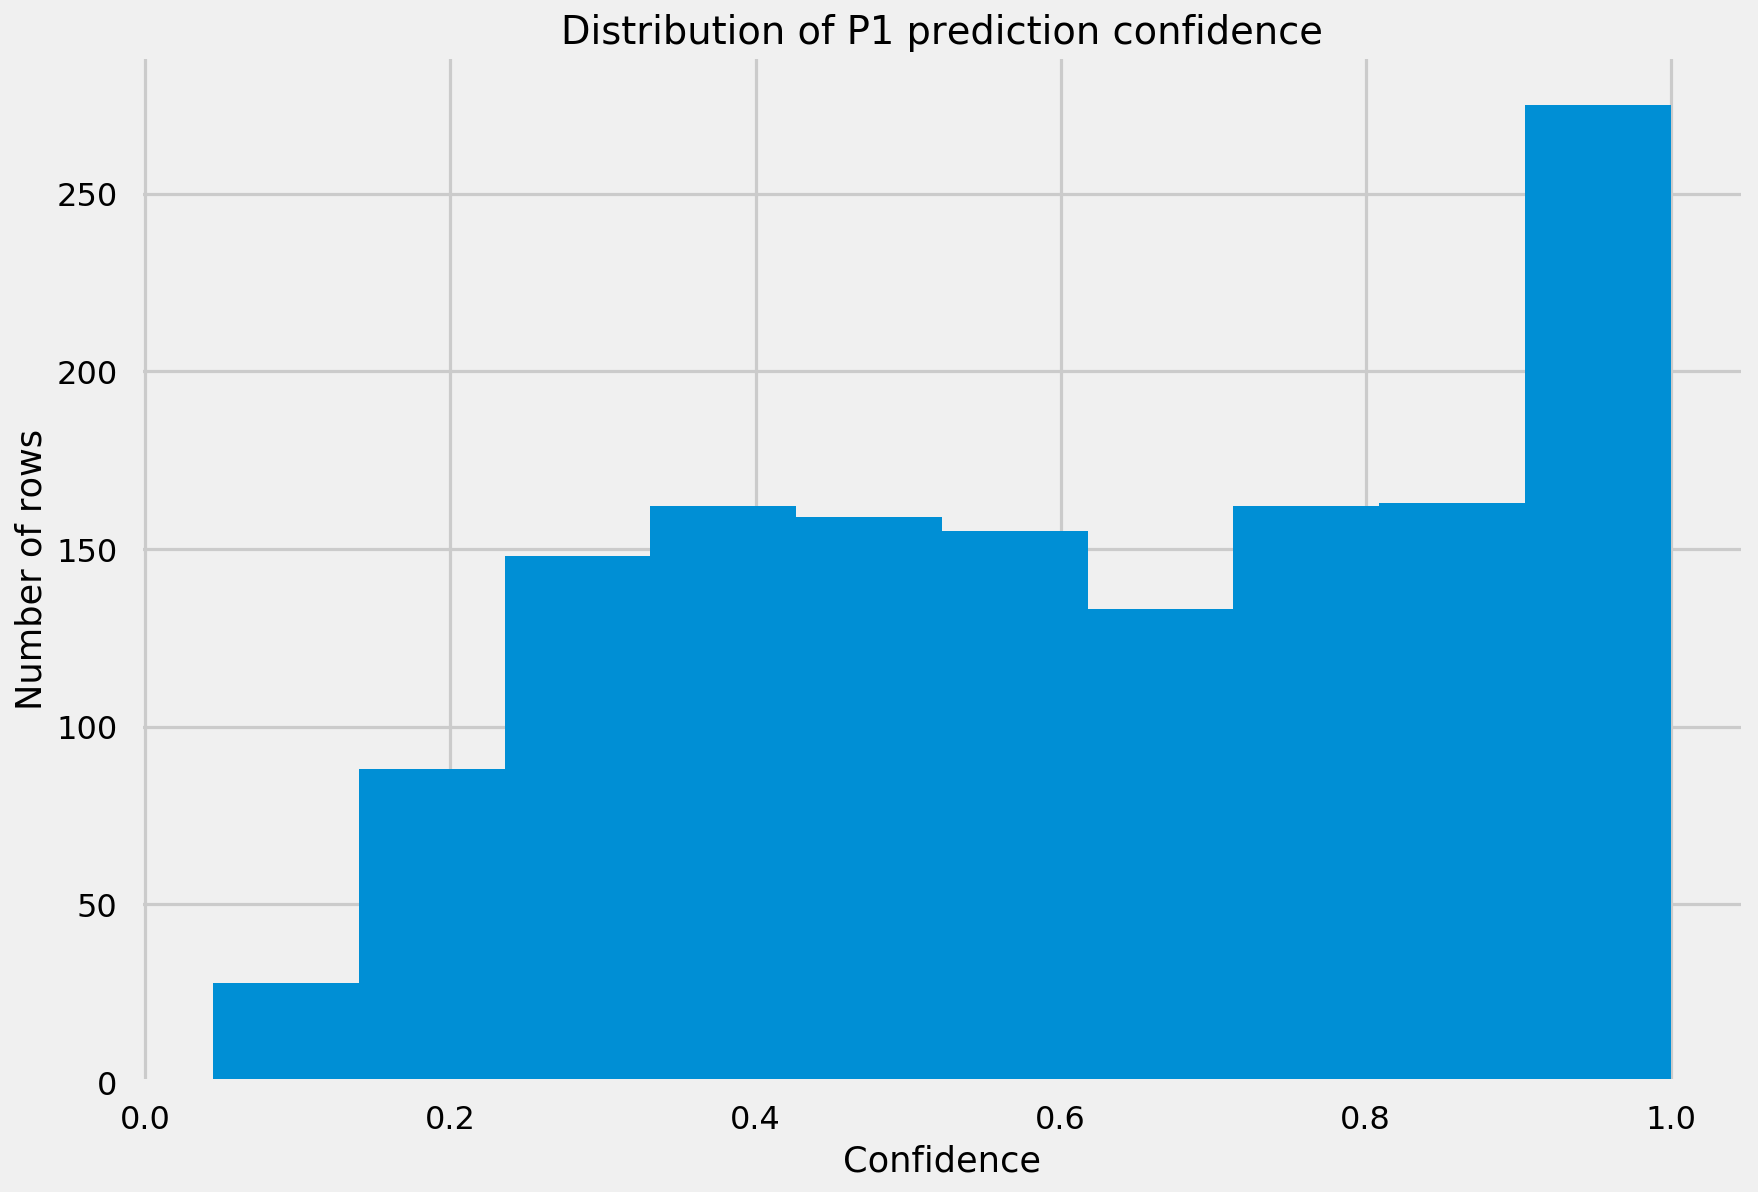

In [52]:
# Histogram of confidence scores for the p1 prediction
plt.hist(df_clean.query('p1_dog == True')['p1_conf'])
plt.title("Distribution of P1 prediction confidence")
plt.xlabel("Confidence")
plt.ylabel("Number of rows")

After looking at the scores, I've decided a 0.5 confidence level (below the median but above the 25th percentile) is appropriate. Anything that's a dog with a > 0.5 confidence will meet my quality bar. First, let's do a visual test:

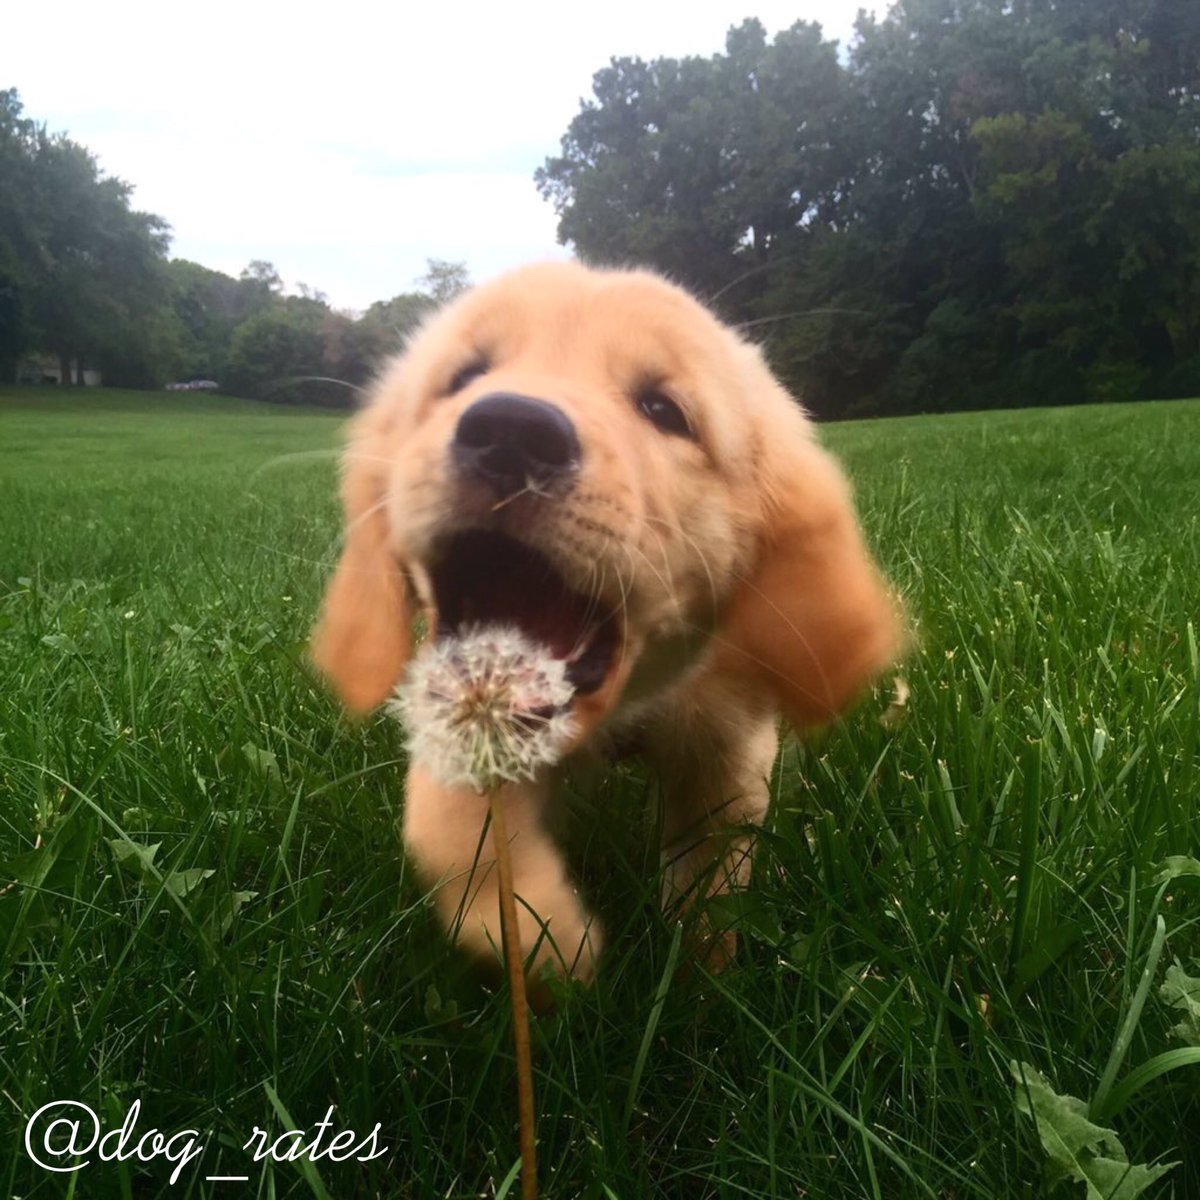

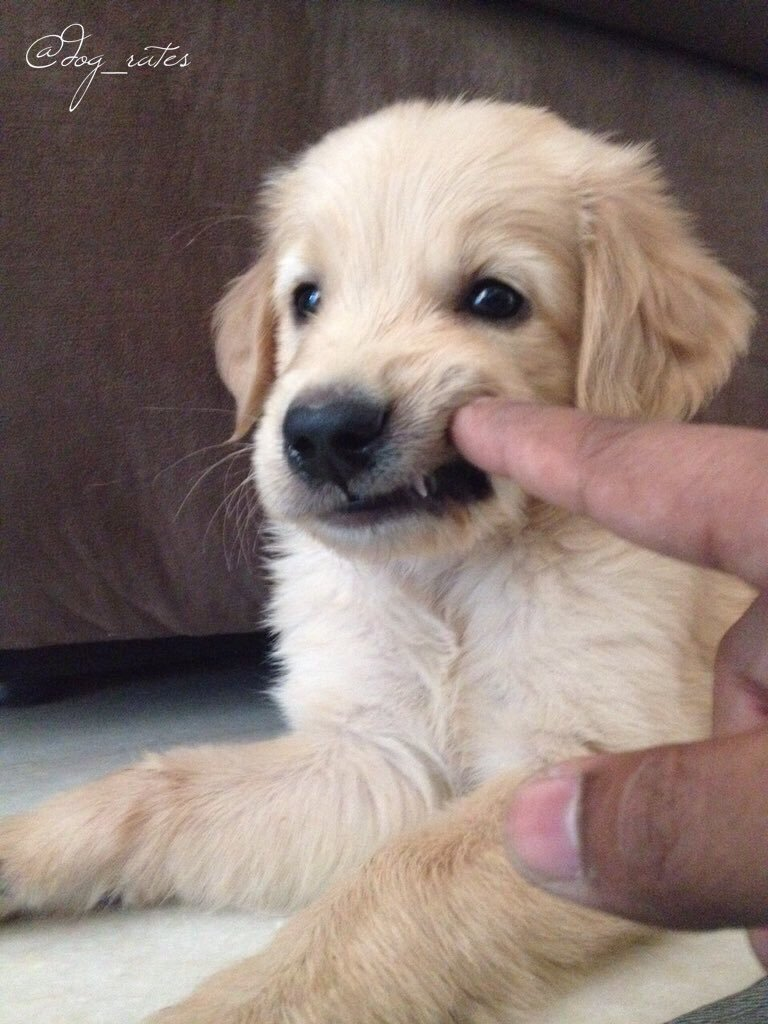

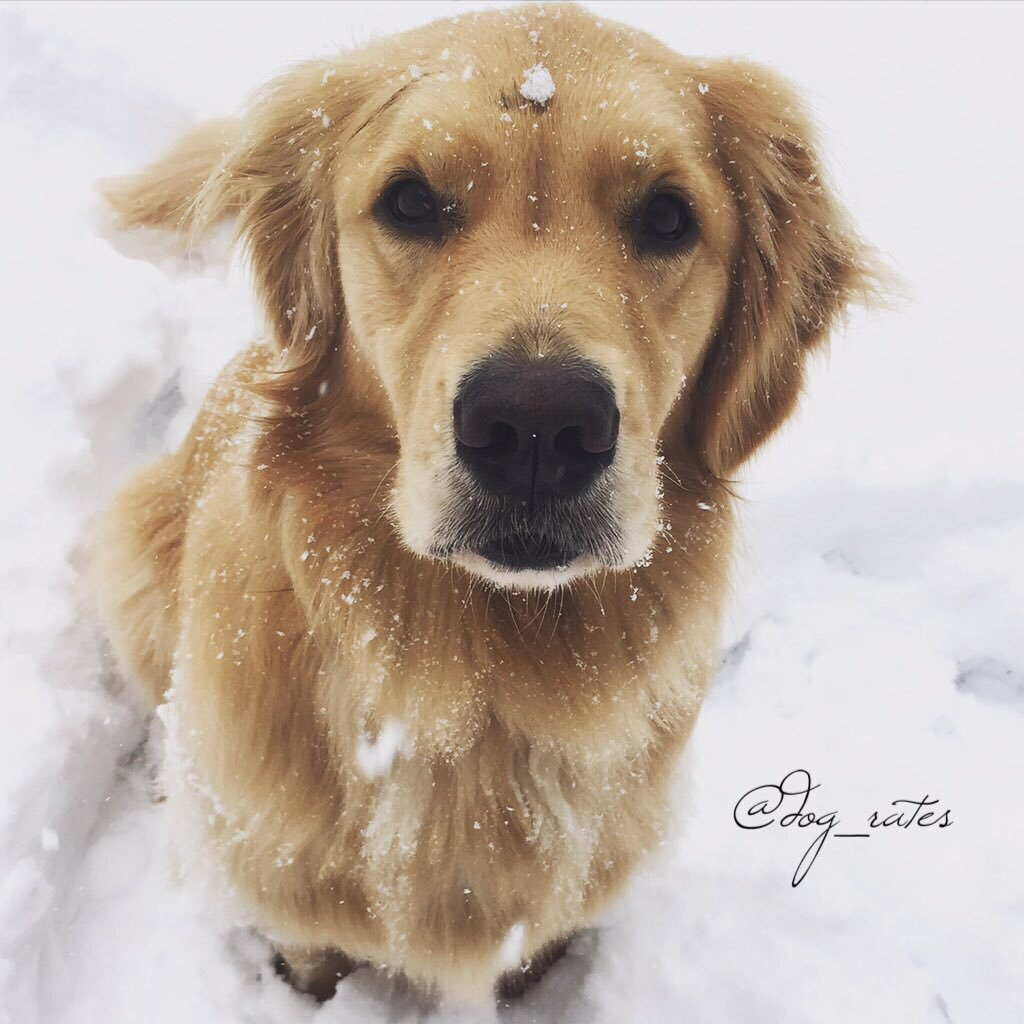

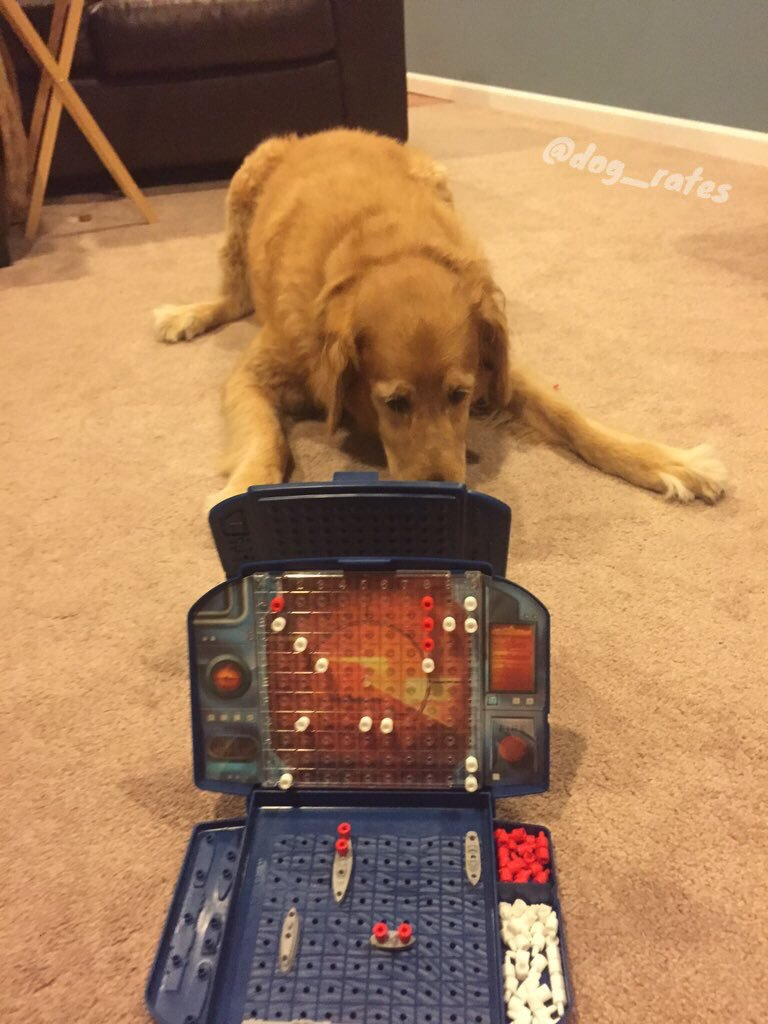

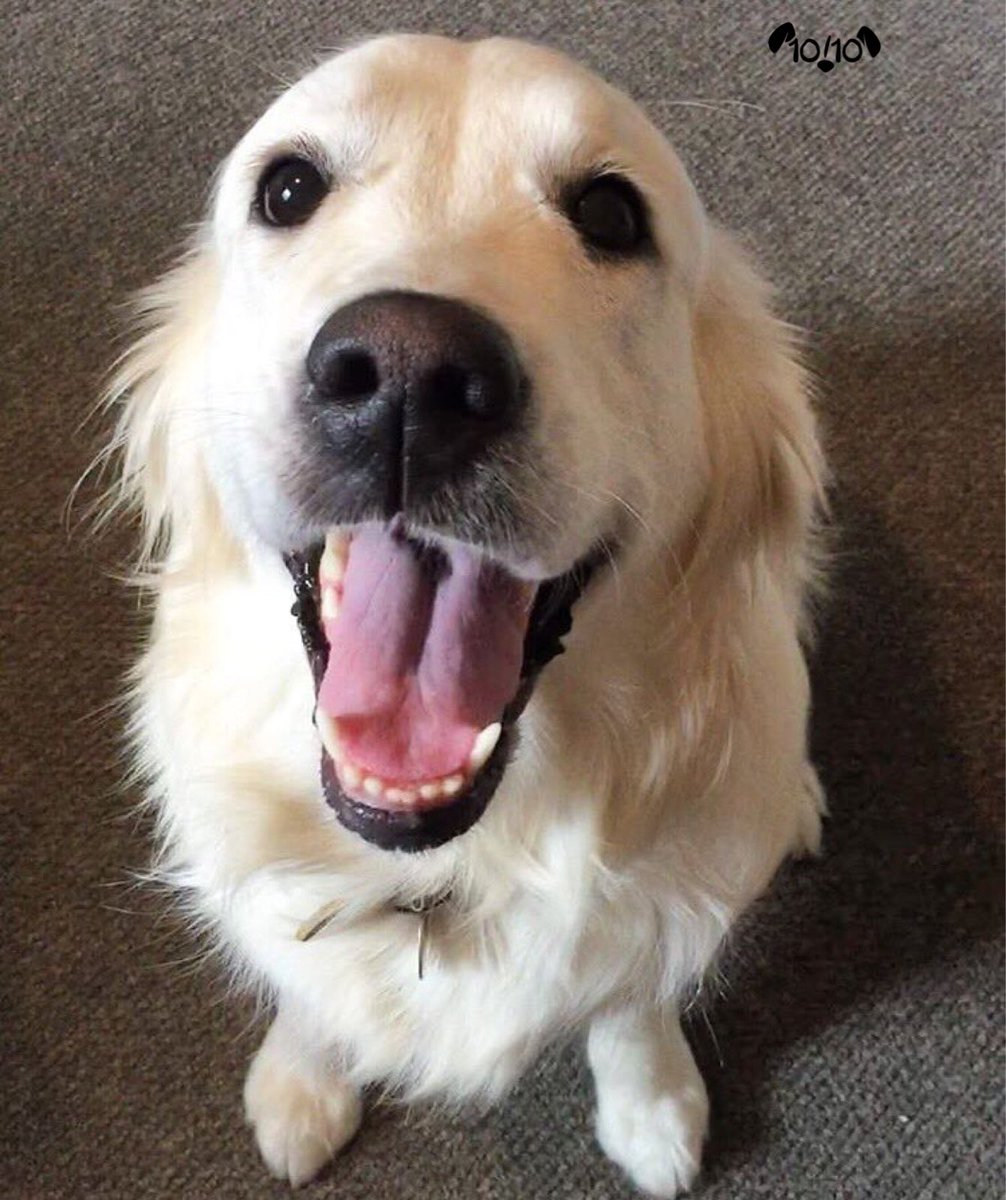

In [53]:
# Pick 10 random golden retrievers at 0.5 confidence
images = df_clean.query('p1 == "golden_retriever" and p1_conf > 0.5').sample(
    n=5)

# Display the images
for i, j in images.iterrows():
    img = Image(url=j['jpg_url'], format='jpg', width=200, embed=True)
    display(img)

Those all look like golden retrievers!

I'll create a new column called `breed` and populate it if the p1 prediction is of a dog and it exceeds 50% confidence. Then I'll drop the `p2*` and `p3*` columns – the neural network's #1 prediction should be good enough for us. 

In [54]:
df_clean['breed'] = np.where(
    (df_clean['p1_dog'] == True) & (df_clean['p1_conf'] > 0.5), df_clean['p1'],
    None)

In [55]:
df_clean.drop([
    'p1', 'p1_dog', 'p1_conf', 'p2', 'p2_dog', 'p2_conf', 'p3', 'p3_dog',
    'p3_conf'
],
              axis=1,
              inplace=True)

**Test**

In [56]:
df_clean.head()

,timestamp,text,expanded_urls,name,jpg_url,img_num,created_at,favorite_count,full_text,lang,retweet_count,source,user,doggie_stage,rating_numerator,rating_denominator,rating,breed
tweet_id,,,,,,,,,,,,,,,,,,
892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,2017-08-01 16:23:56,37511,This is Phineas. He's a mystical boy. Only eve...,en,8182,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",,13.0,10,1.3,None
892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,2017-08-01 00:17:27,32240,This is Tilly. She's just checking pup on you....,en,6053,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",,13.0,10,1.3,None
891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,2017-07-31 00:18:03,24293,This is Archie. He is a rare Norwegian Pouncin...,en,4004,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",,12.0,10,1.2,chihuahua
891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,2017-07-30 15:58:51,40854,This is Darla. She commenced a snooze mid meal...,en,8324,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",,13.0,10,1.3,None
891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,2017-07-29 16:00:24,39059,This is Franklin. He would like you to stop ca...,en,9032,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",,12.0,10,1.2,basset


### Tidyness Issue: Make a new "social total" column

I'm going to be looking at the patterns of retweets and favorites for individual tweets, so I'll create a new combined derived column called `social_total` that equals the sum of `favorite_count` and `retweet_count` so I don't need to keep having to perform this arithmetic.

In [57]:
df_clean['social_total'] = df_clean['favorite_count'] + df_clean['retweet_count']

## Save cleaned data

I feel good about our results. Here's what we ended up with:

In [58]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 892420643555336193 to 666020888022790149
Data columns (total 19 columns):
timestamp             1990 non-null datetime64[ns, UTC]
text                  1990 non-null object
expanded_urls         1990 non-null object
name                  1990 non-null object
jpg_url               1990 non-null object
img_num               1990 non-null int64
created_at            1990 non-null datetime64[ns]
favorite_count        1990 non-null int64
full_text             1990 non-null object
lang                  1990 non-null object
retweet_count         1990 non-null int64
source                1990 non-null object
user                  1990 non-null object
doggie_stage          1990 non-null object
rating_numerator      1990 non-null float64
rating_denominator    1990 non-null int64
rating                1990 non-null float64
breed                 933 non-null object
social_total          1990 non-null int64
dtypes: datetime64[ns, UTC](

In [59]:
df_clean.describe()

,img_num,favorite_count,retweet_count,rating_numerator,rating_denominator,rating,social_total
count,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000
mean,1.203015,8586.705025,2604.044724,12.237578,10.533166,1.164805,11190.749749
std,0.561001,12608.318323,4653.325303,41.512839,7.328029,4.068382,17020.643528
min,1.000000,76.000000,11.000000,0.000000,2.000000,0.000000,87.000000
25%,1.000000,1848.250000,582.250000,10.000000,10.000000,1.000000,2466.000000
50%,1.000000,3880.500000,1249.500000,11.000000,10.000000,1.100000,5133.000000
75%,1.000000,10700.500000,2965.750000,12.000000,10.000000,1.200000,13714.250000
max,4.000000,162019.000000,82408.000000,1776.000000,170.000000,177.600000,244427.000000


We're going to save a copy of the cleaned data frame to a CSV file.

In [60]:
df_clean.to_csv('data/twitter_archive_master.csv')

## Analysis

 Provide **at least three (3) insights** and **one (1) visualization**.

### Question: Has WeRateDogs' popularity (social feedback) changed over time?

Retweets and favorites are indications of a tweets popularity, which in turn are indications of a Twitter account's popularity. I'm interested in learning if the "social feedback" (`social_total`) WeRateDogs is receiving has increased over time.

In [61]:
# Resample our df so we have monthly average totals
df2 = df_clean.set_index('timestamp')
df2 = df2.resample('M').mean()

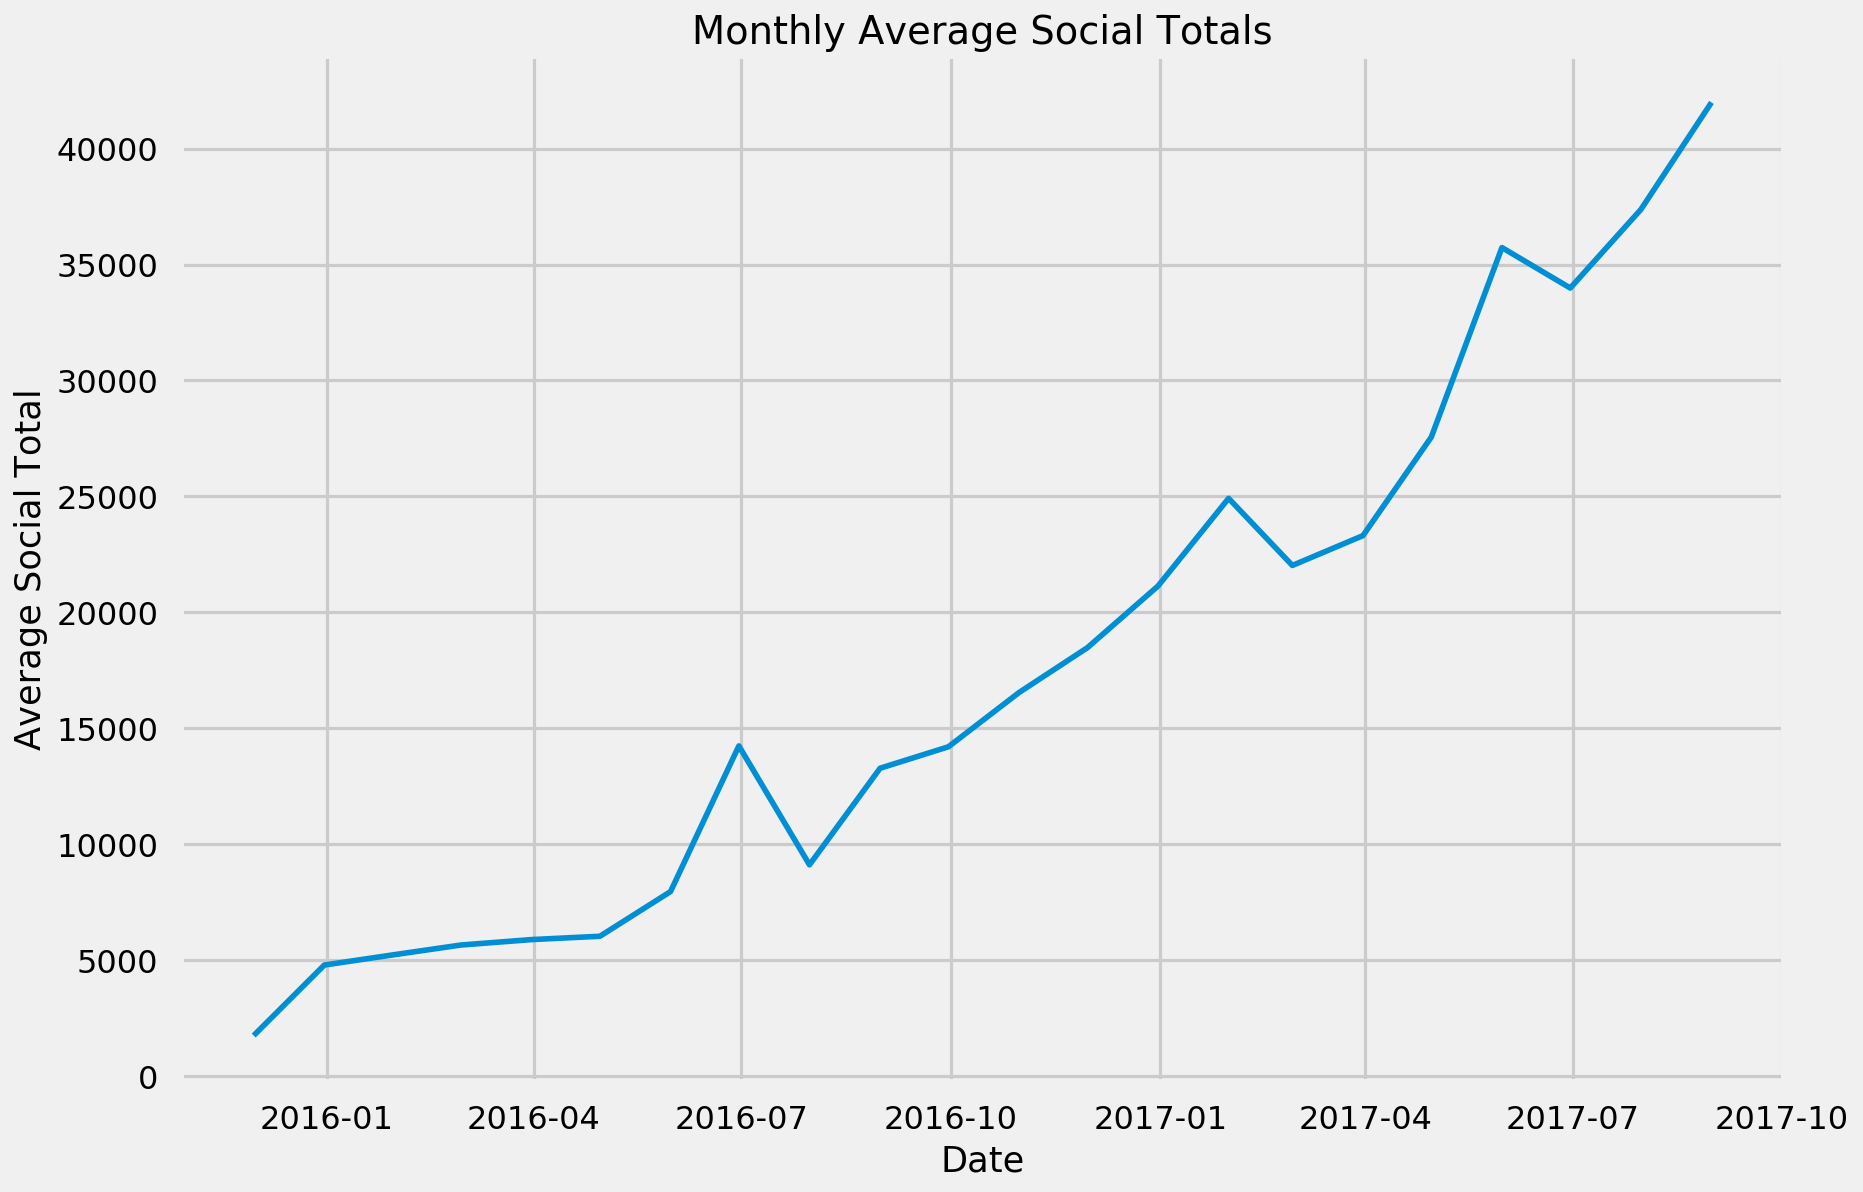

In [62]:
plt.plot(df2.index, df2['social_total'])
plt.title("Monthly Average Social Totals")
plt.xlabel("Date")
plt.ylabel("Average Social Total")
plt.show()

We see that WeRateDogs' average social feedback per tweet has increased significantly as the account has become more popular. We see the same effect if we look at *total* social feedback (a sum of all RTs+tweets for all tweets in a given month).

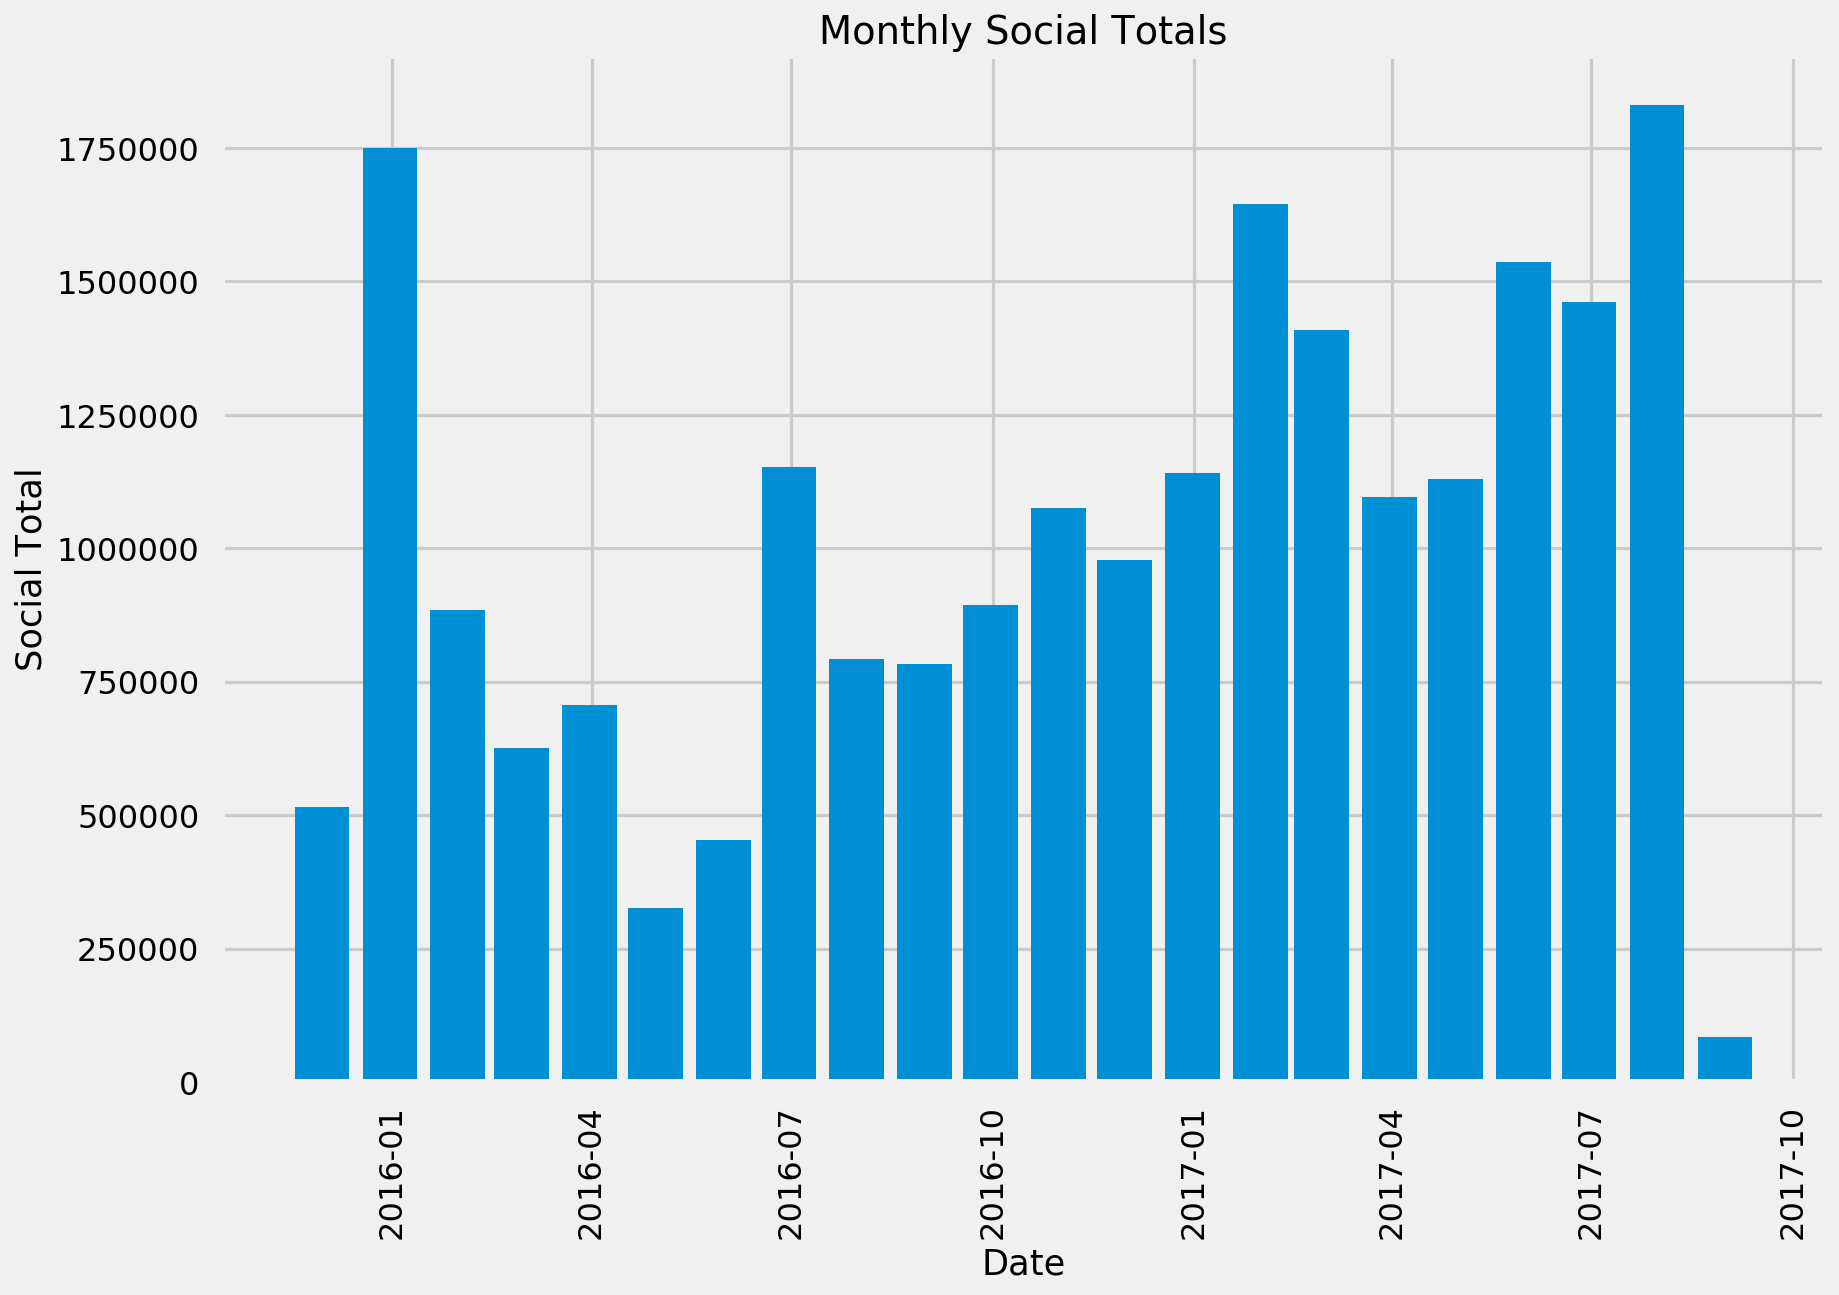

In [63]:
df2 = df_clean.set_index('timestamp')
df2 = df2.resample('M').sum()
plt.bar(df2.index, df2['social_total'], width=25)
plt.xticks(rotation=90)
plt.title("Monthly Social Totals")
plt.xlabel("Date")
plt.ylabel("Social Total")
plt.show()

We do notice a significant drop-off in the last month of our dataset. I suspect this is due to incomplete data from a partial month. I can confirm this.

In [64]:
df_clean.timestamp.max()

Timestamp('2017-08-01 16:23:56+0000', tz='UTC')

And indeed we see the last row in our dataset is from August 1, 2017. Since August 2017 is a partial month's worth of data, we can safely ignore the last month on our plot.

### Question: Do certain dog breeds get higher ratings?

In [65]:
# Add an intercept to the dataframe to support regression
df_clean['intercept'] = 1

First let's check to see if the various doggie stages get higher ratings. Let's run a multiple linear regression to see whether or not these differences are significant.

Our **null hypothesis** is that the mean rating for a particular doggie stage ($\mu_{stage}$) is equal to the mean for the overall population ($\mu$):

$$\Large N_{0} : \mu_{stage} = \mu$$

Our **alternative hypothesis** is that the mean rating for a particular doggie stage ($\mu_{stage}$) is _not_ equal to the mean for the overall population:

$$\Large N_{1} :  \mu_{stage} \neq \mu$$

Our $\alpha$ (alpha) will be 0.05. That means that to reject the null hypothesis, a result must be expected to occur less than 5% of the time in a chance model. We will need to see a p-value $\leq$ 0.05.

In [66]:
stage_dummies = pd.get_dummies(df_clean['doggie_stage'])
df_new = df_clean.join(stage_dummies)

lm_doggie = sm.OLS(
    df_new['rating'], df_new[[
        'intercept', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
        'doggo,floofer', 'doggo,pupper'
    ]])
results_doggie = lm_doggie.fit()
results_doggie.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.02075
Date:                Fri, 24 May 2019   Prob (F-statistic):               1.00
Time:                        10:46:05   Log-Likelihood:                -5615.6
No. Observations:                1990   AIC:                         1.125e+04
Df Residuals:                    1982   BIC:                         1.129e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         1.1758      0.099     11.839      0.000       0.981       1.371
doggo             0.0131      0.523      0.025      0.980      -1.013       1.039
puppo             0.0242      0.875      0.028      0.978      -1.691       1.739
pupper           -0.1121      0.303     -0.370      0.711      -0.706       0.482
floofer           0.0242      1.544      0.016      0.987      -3.003       3.051
doggo,puppo       0.1242      4.077      0.030      0.976      -7.871       8.119
doggo,floofer    -0.0758      4.077     -0.019      0.985      -8.071       7.919
doggo,pupper     -0.0758      1.362     -0.056      0.956      -2.747       2.595
==============================================================================
Omnibus:                     5941.933   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        263630491.410
Skew:                          41.522   Prob(JB):                         0.00
Kurtosis:                    1784.170   Cond. No.                         44.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion: none of the p-values are under our $\alpha$ of 0.05 so we fail to reject the null hypothesis: the mean of the ratings for the various doggie stages equals the mean ratings for the overall population.

### Question: Do certain dog breeds get more social feedback?

On Twitter, there are several different ways for tweets to receive feedback from other users. The most prominent are favorites (likes) and retweets. When users retweet, they share the tweet with their own followers, bringing it to a new audience and promoting virality.

Above I created a new column called `social_total` that sums retweets and favorites. I was operating under the assumption that the two values are correlated. Before proceeding, let's test that assumption.

In [67]:
# Are favorites and RT's correlated?
df_clean['favorite_count'].corr(df_clean['retweet_count'])

0.9295896613605447

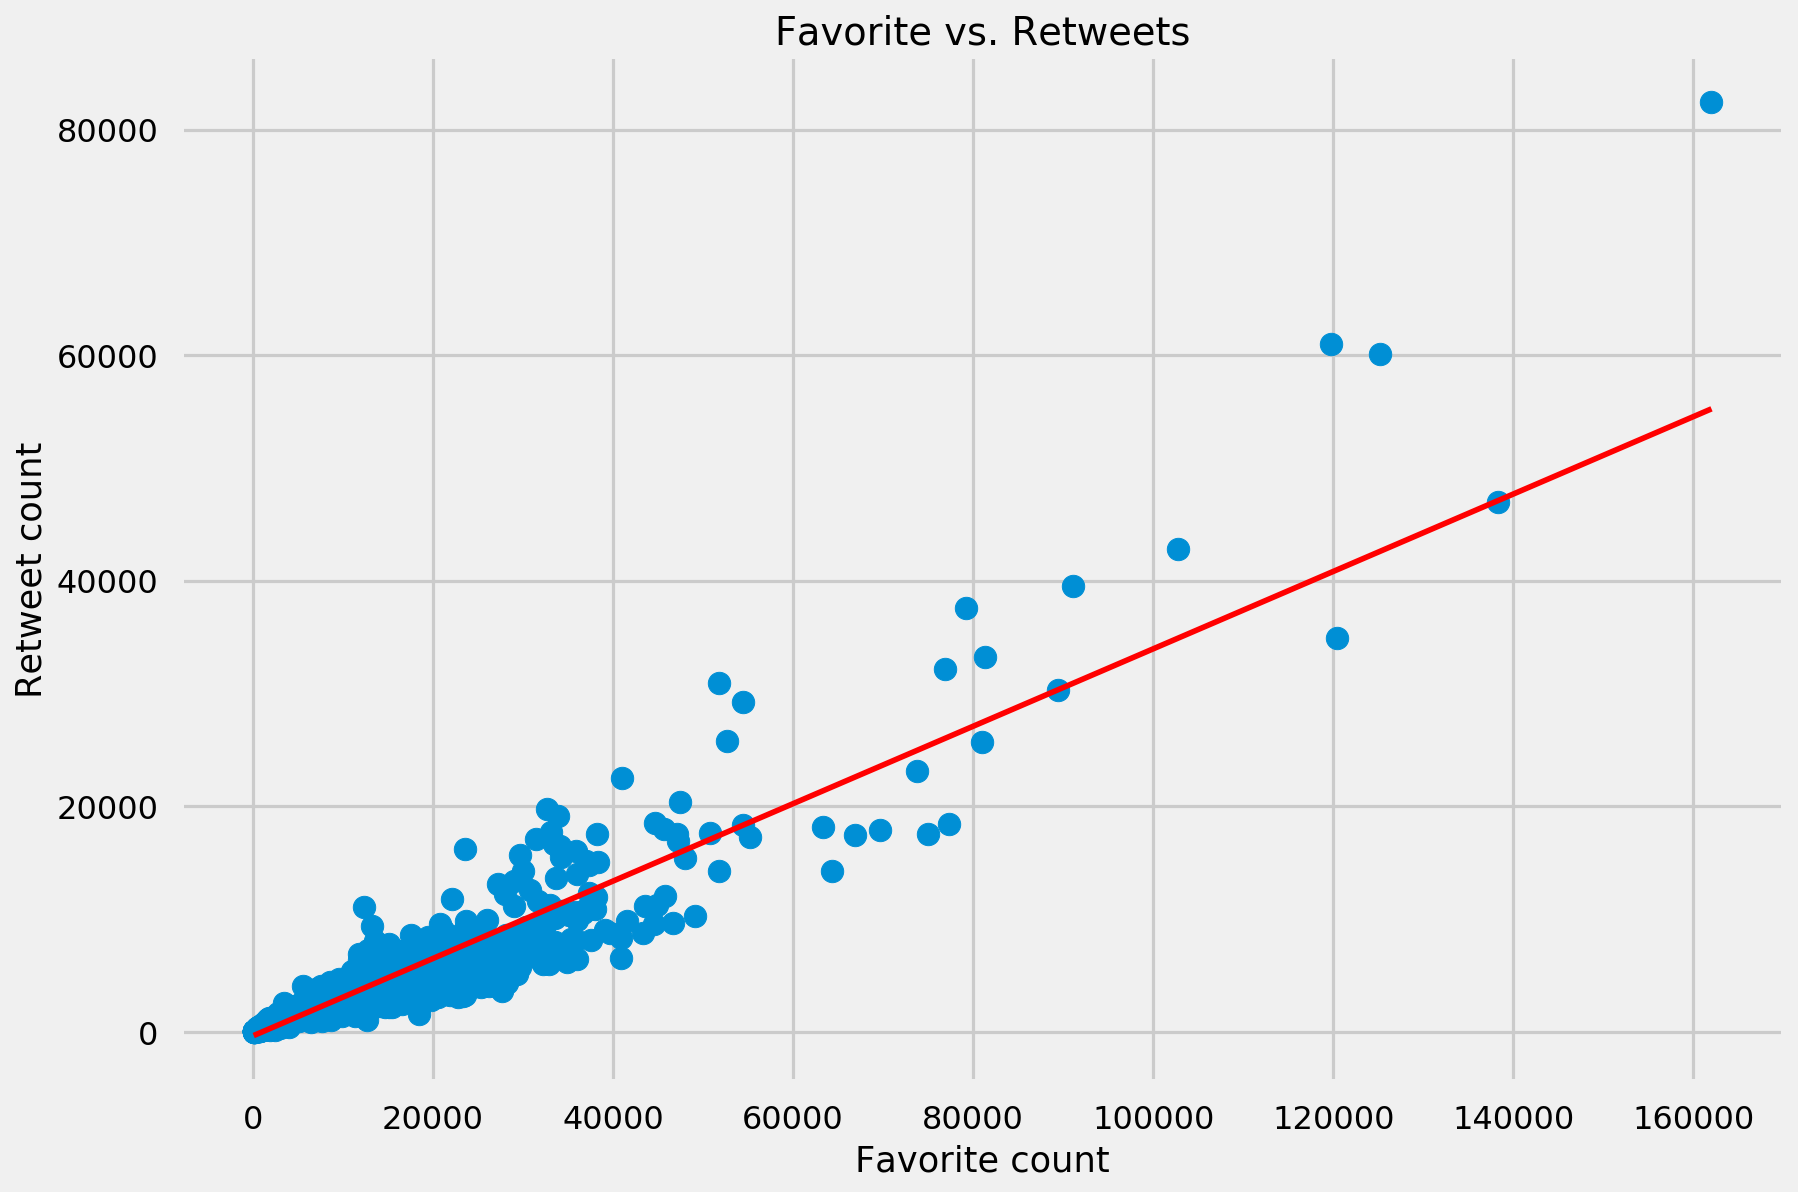

In [68]:
plt.scatter(df_clean['favorite_count'], df_clean['retweet_count'])
plt.title("Favorite vs. Retweets")
plt.xlabel("Favorite count")
plt.ylabel("Retweet count")
plt.plot(np.unique(df_clean['favorite_count']),
         np.poly1d(
             np.polyfit(df_clean['favorite_count'], df_clean['retweet_count'],
                        1))(np.unique(df_clean['favorite_count'])),
         color='r')
plt.show()

Conclusion: Yes! Retweet and favorite count is strongly positively correlated (0.93). Since the two social signals are so highly correlated I can have confidence in my analysis.

In [69]:
# What are the top 25 most detected dogs?
df_clean.query('breed != "None"').groupby('breed')['rating'].agg(
    'count').sort_values(ascending=False).head(25)

breed
golden_retriever               116
pembroke                        70
labrador_retriever              63
chihuahua                       47
pug                             43
samoyed                         29
pomeranian                      29
chow                            26
toy_poodle                      24
french_bulldog                  21
german_shepherd                 19
malamute                        18
maltese_dog                     15
cocker_spaniel                  14
shetland_sheepdog               12
cardigan                        12
shih-tzu                        11
chesapeake_bay_retriever        11
miniature_pinscher              11
west_highland_white_terrier     11
bernese_mountain_dog            10
vizsla                          10
rottweiler                      10
staffordshire_bullterrier       10
pekinese                         9
Name: rating, dtype: int64

In [70]:
# Take the top 15 most popular breeds in our dataset and add them to
# a new list
top_breeds = df_clean.query('breed != "None"').groupby('breed')['breed'].count(
).sort_values(ascending=False).head(15).index.tolist()
top_breeds

['golden_retriever',
 'pembroke',
 'labrador_retriever',
 'chihuahua',
 'pug',
 'samoyed',
 'pomeranian',
 'chow',
 'toy_poodle',
 'french_bulldog',
 'german_shepherd',
 'malamute',
 'maltese_dog',
 'cocker_spaniel',
 'shetland_sheepdog']

In [71]:
# Create a new df with only the top breeds 
# so there are enough values for each breed
df_top_breeds = df_clean[df_clean['breed'].isin(top_breeds)]

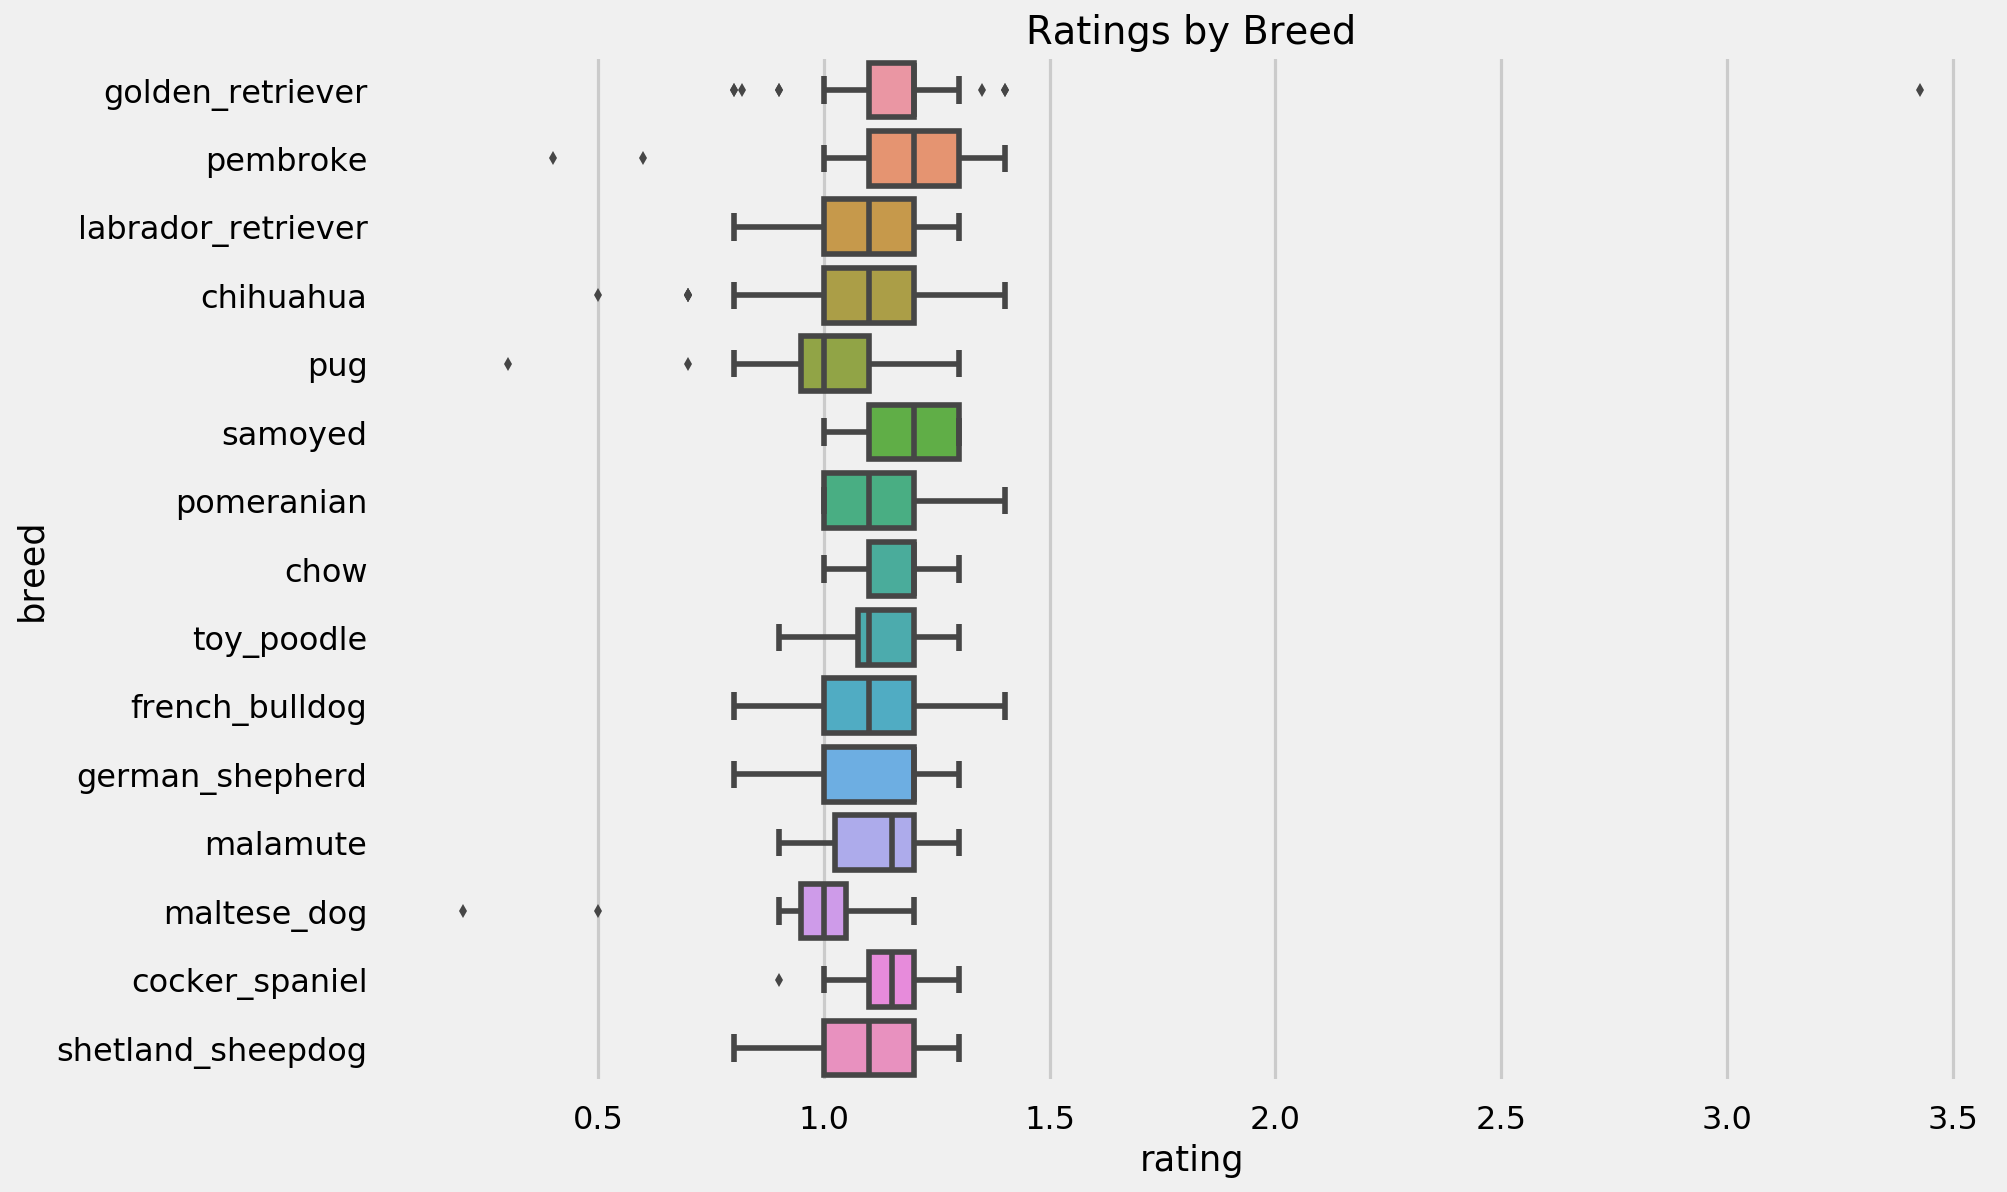

In [72]:
ax = sns.boxplot(data=df_top_breeds,
                 y="breed",
                 x="rating",
                 order=top_breeds,
                 orient='h')
plt.title("Ratings by Breed")
plt.show()

Let's look at how many RTs+favorites tweets get when they include dogs from each of the top breeds. I'm using a log scale so we can get a better sense for distribution.

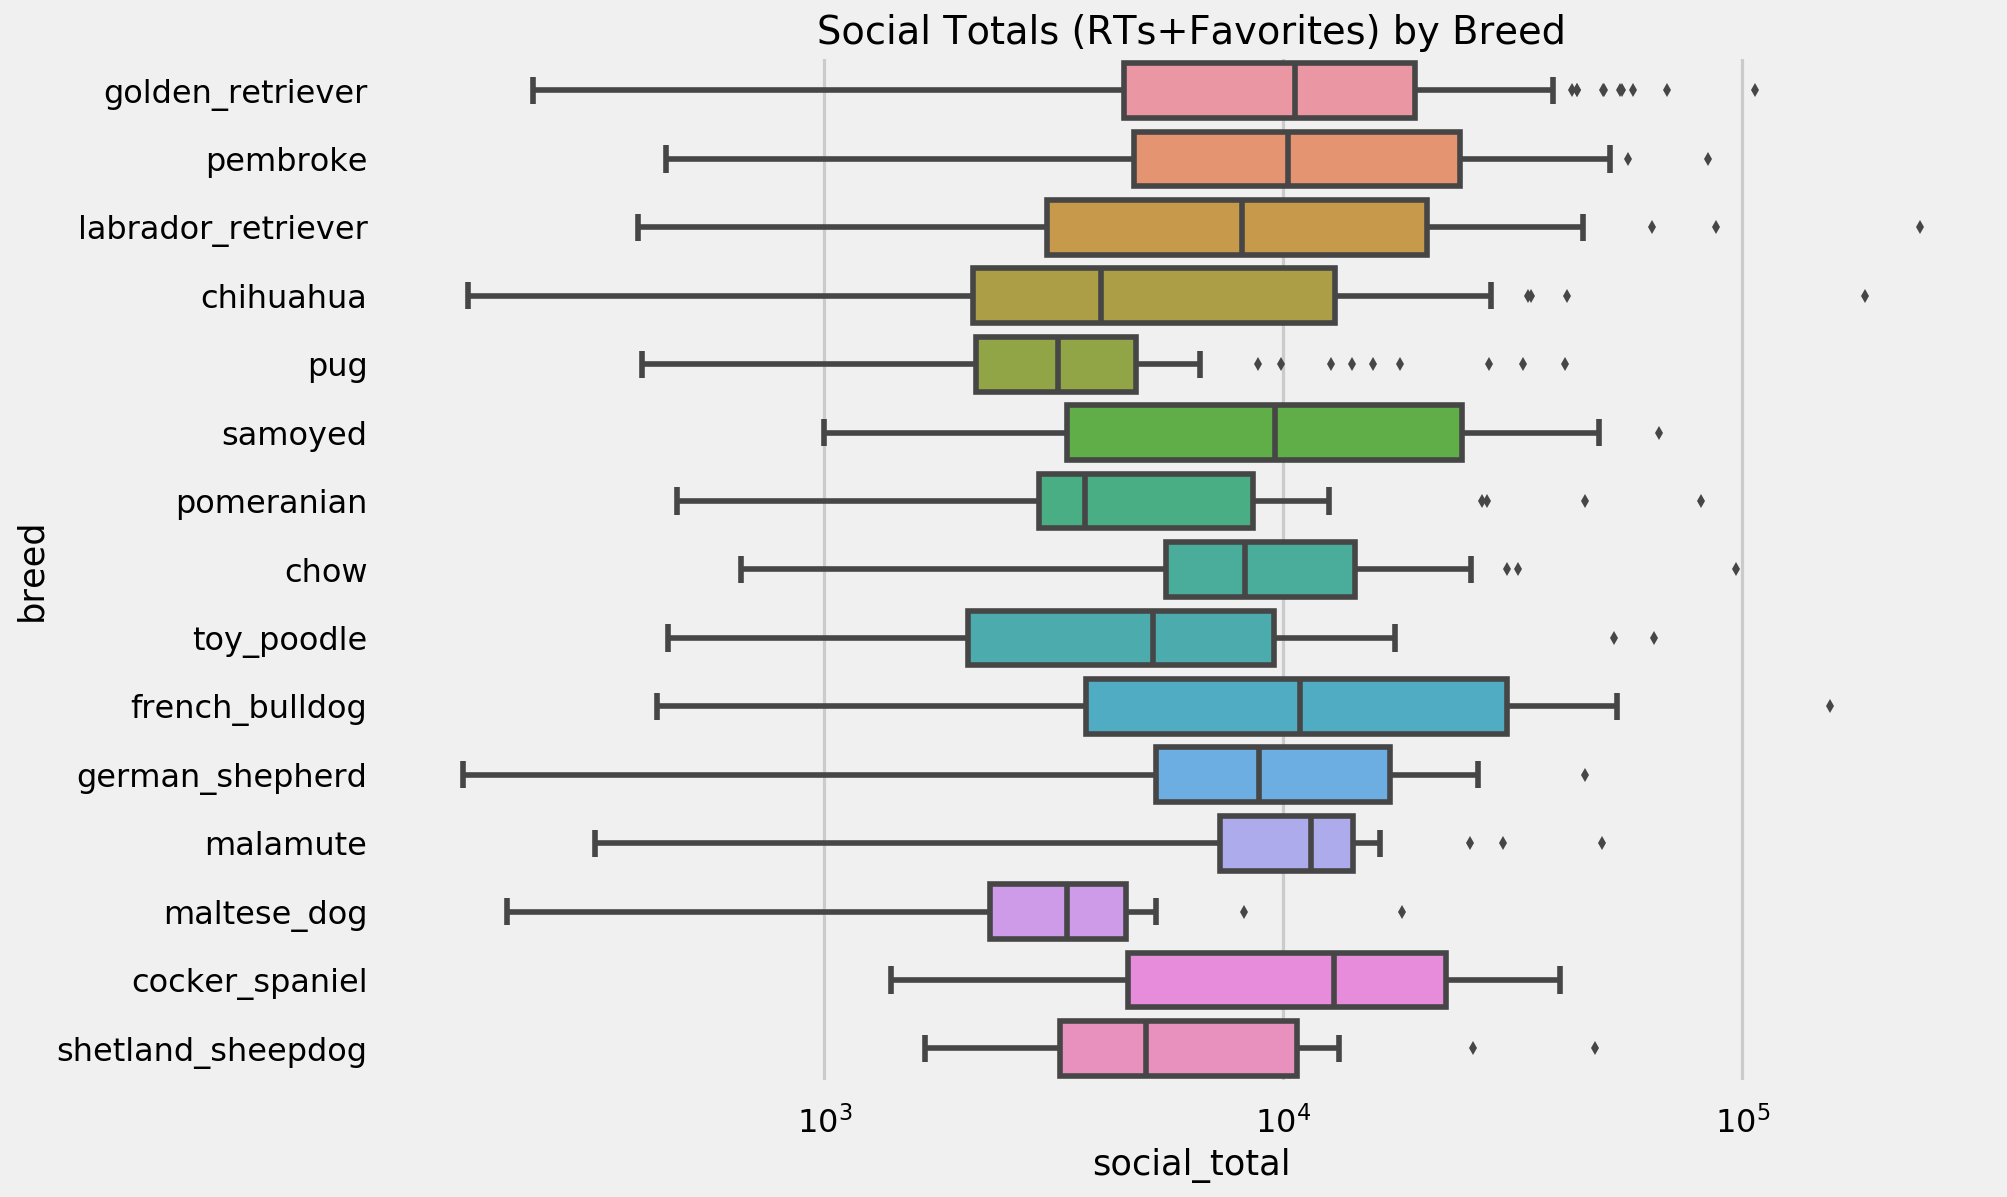

In [73]:
ax = sns.boxplot(data=df_top_breeds,
                 y="breed",
                 x="social_total",
                 order=top_breeds,
                 orient='h')
plt.title("Social Totals (RTs+Favorites) by Breed")
ax.set_xscale('log')
plt.show()

In [74]:
# Which breeds have the highest average number of RTs+favorites?
df_top_breeds.groupby('breed').social_total.mean().sort_values(
    ascending=False)

breed
french_bulldog        23265.190476
labrador_retriever    17374.809524
samoyed               16703.655172
pembroke              15972.814286
golden_retriever      15496.077586
cocker_spaniel        15097.285714
chow                  14217.038462
malamute              13503.833333
german_shepherd       12283.473684
chihuahua             12274.297872
shetland_sheepdog     10714.833333
pomeranian            10094.862069
toy_poodle             9929.458333
pug                    6420.232558
maltese_dog            4321.866667
Name: social_total, dtype: float64

In [75]:
# Which breeds have the highest median number of RTs+favorites?
df_top_breeds.groupby('breed').social_total.median().sort_values(
    ascending=False)

breed
cocker_spaniel        12872.0
malamute              11488.0
french_bulldog        10851.0
golden_retriever      10622.5
pembroke              10241.0
samoyed                9569.0
german_shepherd        8855.0
chow                   8243.5
labrador_retriever     8138.0
toy_poodle             5206.0
shetland_sheepdog      5021.5
chihuahua              4008.0
pomeranian             3697.0
maltese_dog            3372.0
pug                    3231.0
Name: social_total, dtype: float64

In [76]:
# Which breeds have the highest *total* number of RTs+favorites
df_top_breeds.groupby('breed').social_total.sum().sort_values(
    ascending=False)

breed
golden_retriever      1797545
pembroke              1118097
labrador_retriever    1094613
chihuahua              576892
french_bulldog         488569
samoyed                484406
chow                   369643
pomeranian             292751
pug                    276070
malamute               243069
toy_poodle             238307
german_shepherd        233386
cocker_spaniel         211362
shetland_sheepdog      128578
maltese_dog             64828
Name: social_total, dtype: int64

Golden Retrievers have the most RTs+favorites by far across all tweets. But French Bulldogs are at the top when it comes to average number of RTs+favorites per tweet, with Labrador Retrievers and Samoyeds in 2nd and 3rd place.

Now let's run a multiple linear regression to see whether or not these differences are significant.

Our **null hypothesis** is that the mean RTs+favorites for a particular breed ($\mu_{breed}$) is equal to the mean for the overall population ($\mu$):

$$\Large N_{0} : \mu_{breed} = \mu$$

Our **alternative hypothesis** is that the mean RTs+favorites for a particular breed ($\mu_{breed}$) is _not_ equal to the mean for the overall population:

$$\Large N_{1} :  \mu_{breed} \neq \mu$$

Our $\alpha$ (alpha) will be 0.05. That means that to reject the null hypothesis, a result must be expected to occur less than 5% of the time in a chance model. We will need to see a p-value $\leq$ 0.05.

In [77]:
breed_dummies = pd.get_dummies(df_clean['breed'])
df_new = df_clean.join(breed_dummies)
df_new.drop(columns = ['breed'], inplace=True)

In [78]:
lm = sm.OLS(
    df_new['social_total'], df_new[[
        'intercept', 'rating', 'golden_retriever', 'pembroke',
        'labrador_retriever', 'chihuahua', 'pug', 'samoyed', 'pomeranian',
        'chow', 'toy_poodle', 'french_bulldog', 'german_shepherd', 'malamute',
        'maltese_dog', 'cocker_spaniel', 'shetland_sheepdog'
    ]])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           social_total   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.147
Date:                Fri, 24 May 2019   Prob (F-statistic):           2.37e-05
Time:                        10:46:07   Log-Likelihood:                -22185.
No. Observations:                1990   AIC:                         4.440e+04
Df Residuals:                    1973   BIC:                         4.450e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept           1.004e+04    457.450     21.944      0.000    9141.359    1.09e+04
rating                91.5030     93.012      0.984      0.325     -90.909     273.915
golden_retriever    5349.3600   1628.570      3.285      0.001    2155.461    8543.259
pembroke            5827.6537   2065.319      2.822      0.005    1777.217    9878.090
labrador_retriever  7234.5001   2172.008      3.331      0.001    2974.830    1.15e+04
chihuahua           2138.8494   2501.310      0.855      0.393   -2766.637    7044.336
pug                -3711.6798   2611.569     -1.421      0.155   -8833.402    1410.042
samoyed             6557.2506   3165.014      2.072      0.038     350.130    1.28e+04
pomeranian           -45.8631   3165.019     -0.014      0.988   -6252.994    6161.268
chow                4071.2042   3339.221      1.219      0.223   -2477.567    1.06e+04
toy_poodle          -211.5955   3473.211     -0.061      0.951   -7023.143    6599.952
french_bulldog      1.312e+04   3709.223      3.538      0.000    5849.895    2.04e+04
german_shepherd     2143.8446   3896.900      0.550      0.582   -5498.627    9786.317
malamute            3361.6358   4002.312      0.840      0.401   -4487.566    1.12e+04
maltese_dog        -5802.0303   4379.870     -1.325      0.185   -1.44e+04    2787.626
cocker_spaniel      4954.8703   4531.982      1.093      0.274   -3933.103    1.38e+04
shetland_sheepdog    577.9734   4891.749      0.118      0.906   -9015.563    1.02e+04
==============================================================================
Omnibus:                     2097.152   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           162570.018
Skew:                           5.124   Prob(JB):                         0.00
Kurtosis:                      46.077   Cond. No.                         54.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion: the following breeds are more likely to generate more RTs+favorites: French Bulldog, Pembroke, Labrador Retriever, Samoyed, Golden Retriever. All have p-values below our $\alpha$ (alpha) of 0.05 and are considered statistically significant. 

For the above breeds and doggie types, we reject our null hypothesis and find:

$$\Large N_{1} :  \mu_{breed} \gt \mu$$

### Question: Which individual dogs have received the most social feedback?

OK, now let's look at individual tweets with individual dogs. Who has the most social feedback, as measured by `social_total`?

In [79]:
# I'm using dropna() here because I only want to include tweets that
# had a detected dog breed. Let's take the Top 5.
df2 = df_clean.dropna().sort_values(by='social_total', ascending=False).head(5)

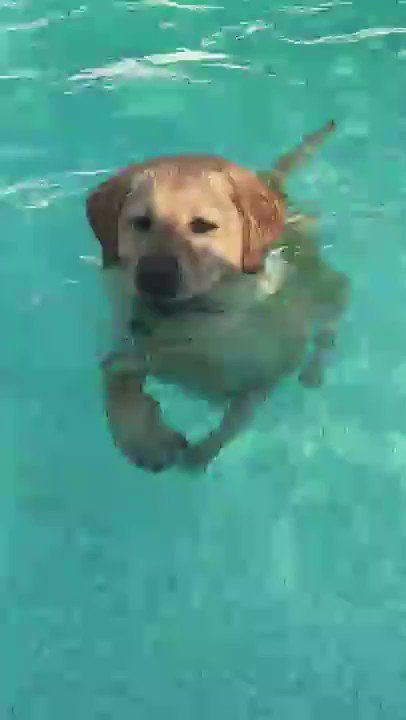

labrador_retriever 
social_total:  244427 
rating:  1.3  ( 13.0 / 10 )


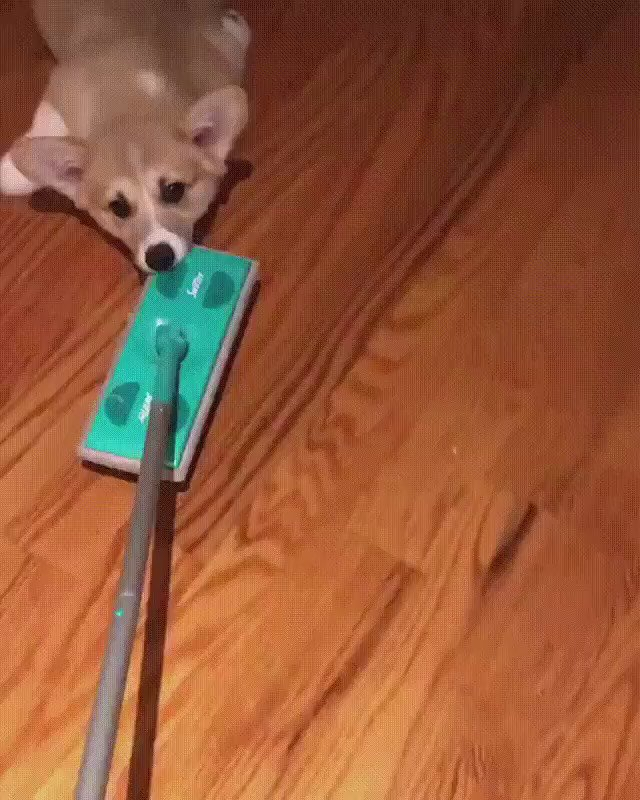

chihuahua 
social_total:  185335 
rating:  1.3  ( 13.0 / 10 )


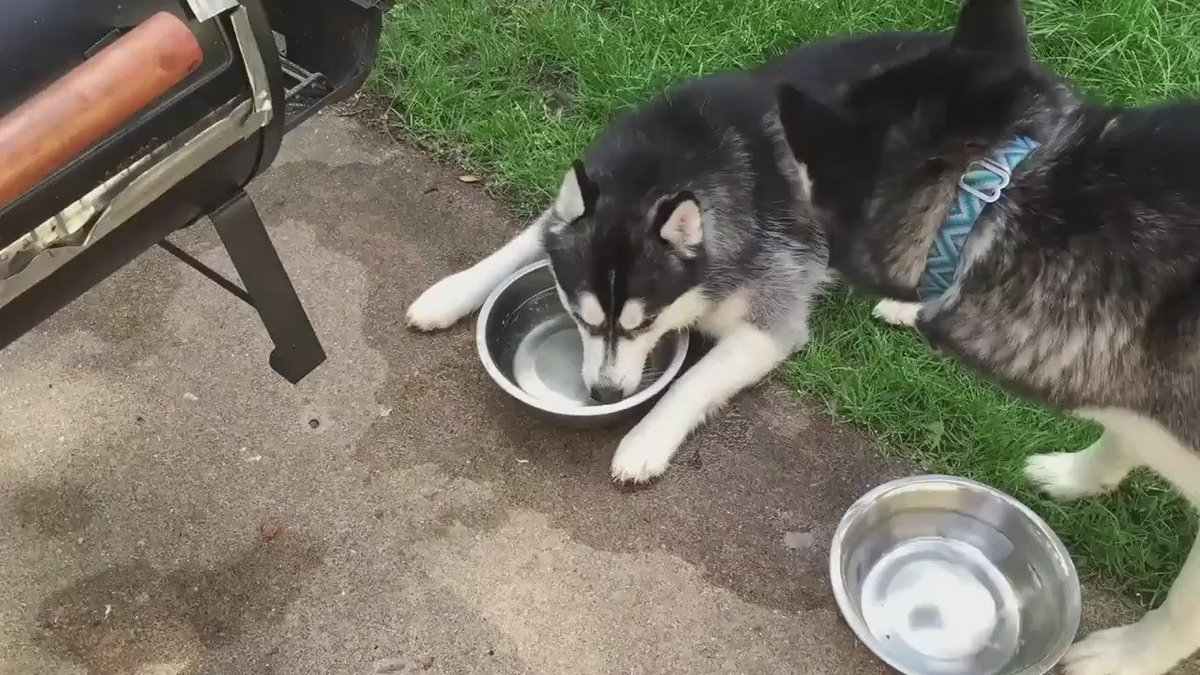

eskimo_dog 
social_total:  180780 
rating:  1.3  ( 13.0 / 10 )


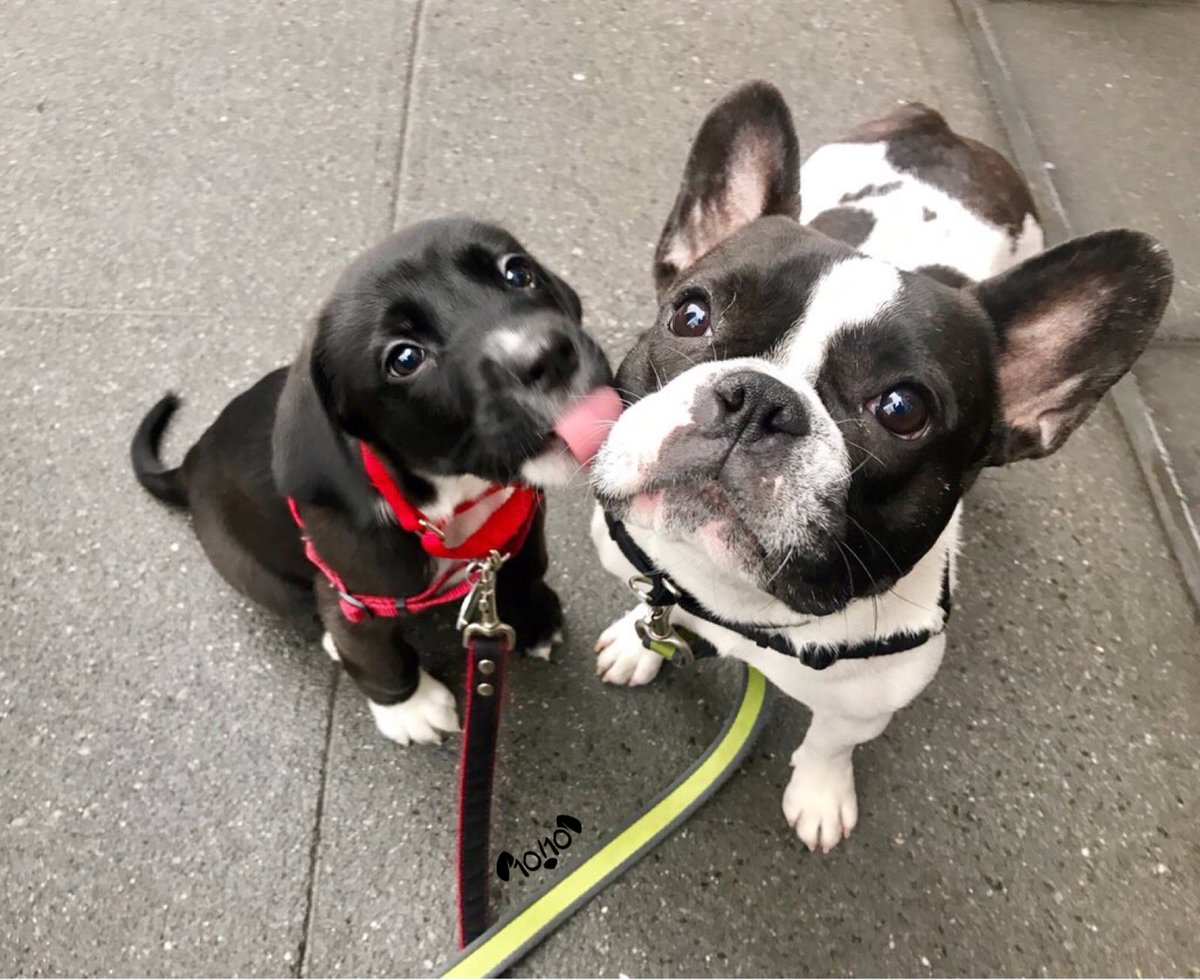

french_bulldog 
social_total:  155293 
rating:  1.3  ( 13.0 / 10 )


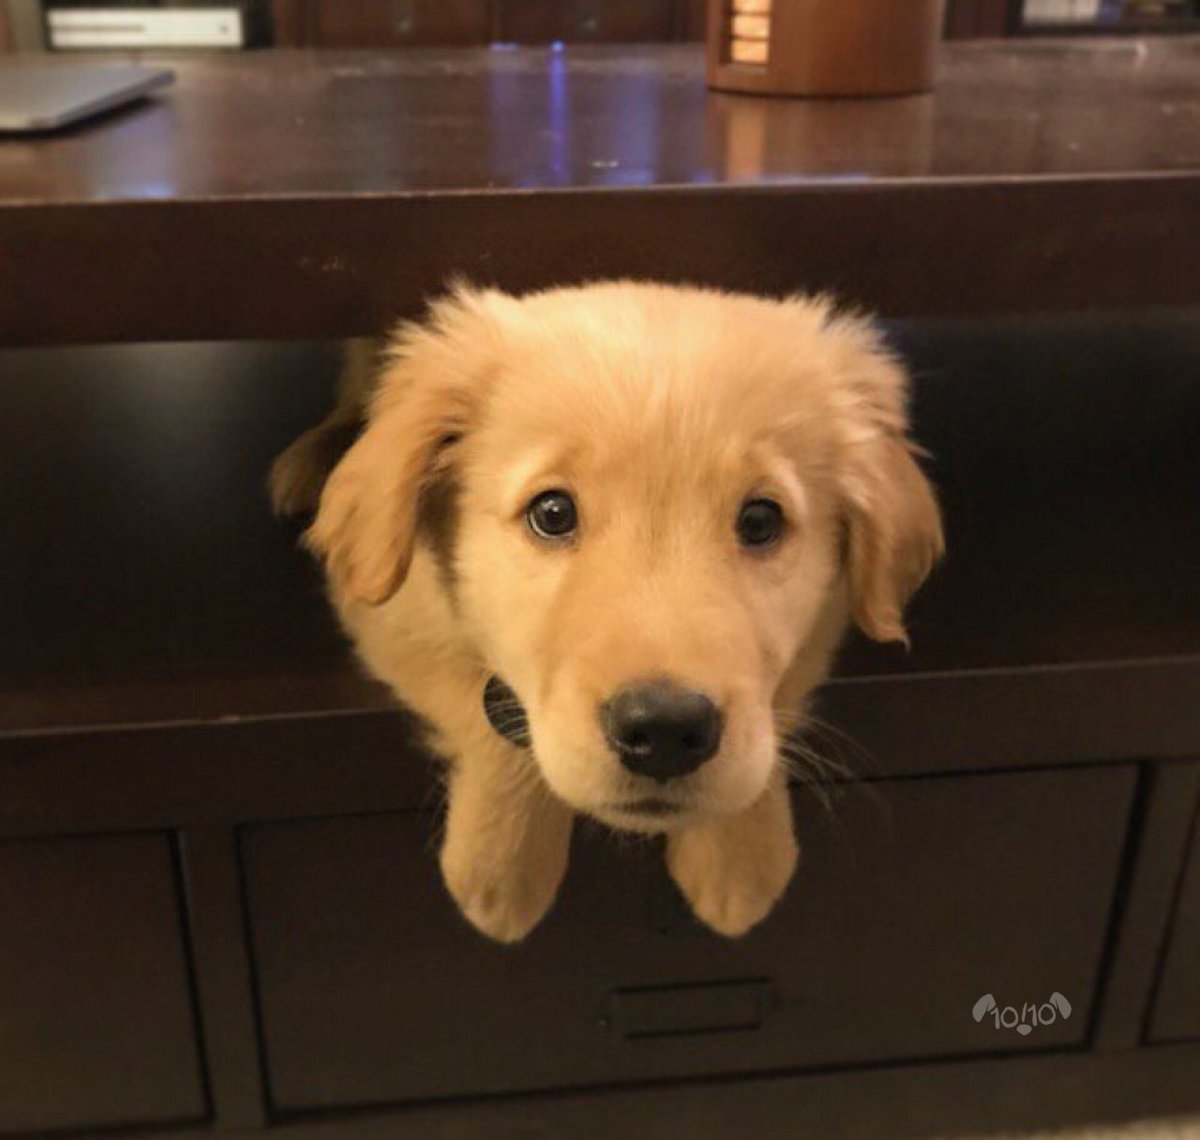

golden_retriever 
social_total:  106703 
rating:  1.3  ( 13.0 / 10 )


In [80]:
# Display the images
for i, j in df2.iterrows():
    img = Image(url=j['jpg_url'], format='jpg', width=200, embed=True)
    display(img)
    print(j['breed'], "\nsocial_total: ", j['social_total'], "\nrating: ",
          j['rating'], " (", j['rating_numerator'], "/",
          j['rating_denominator'], ")")

## Conclusion

Let's wrap things up with a look at 5 random dogs from the breeds most likely to resonate with Twitter users.

They're good dogs, Brent.

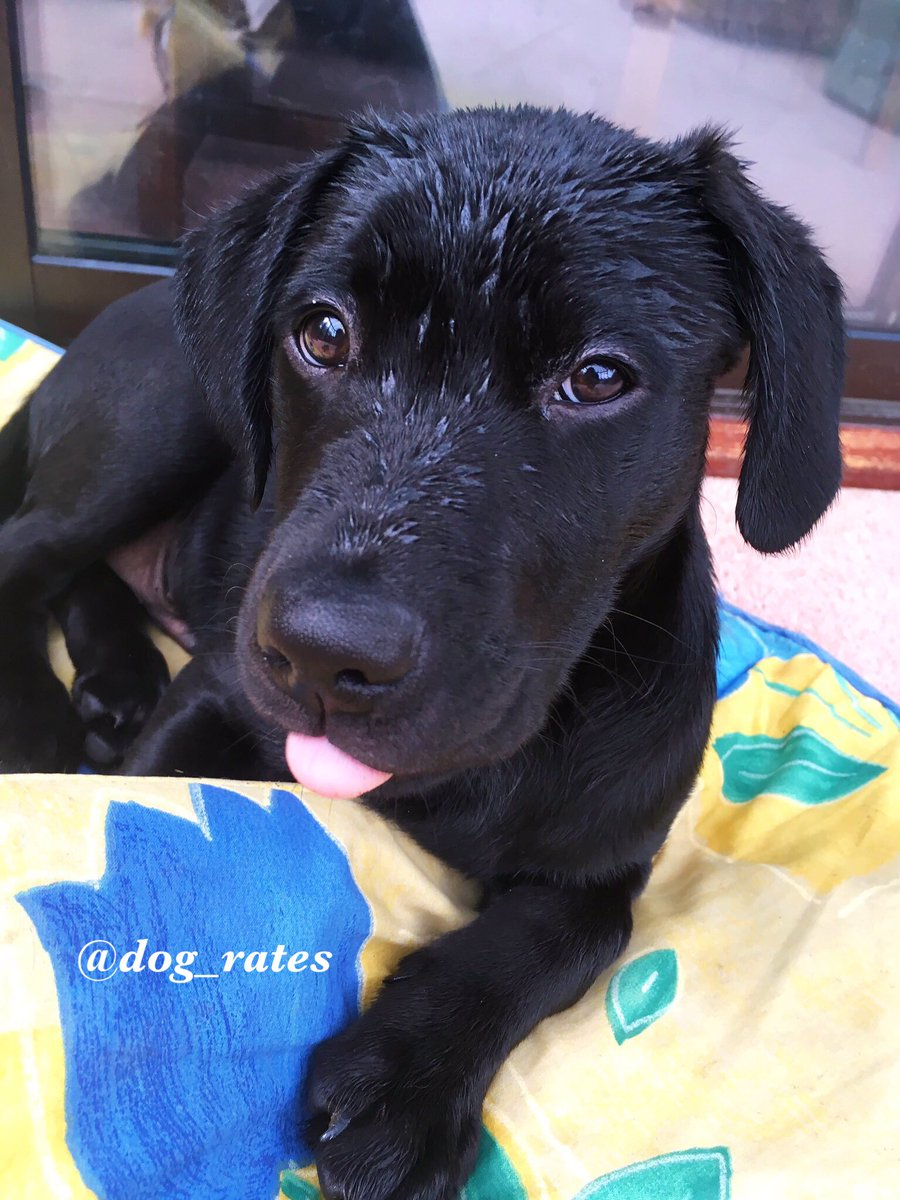

labrador_retriever 
social_total:  17093 
rating:  1.2  ( 12.0 / 10 )


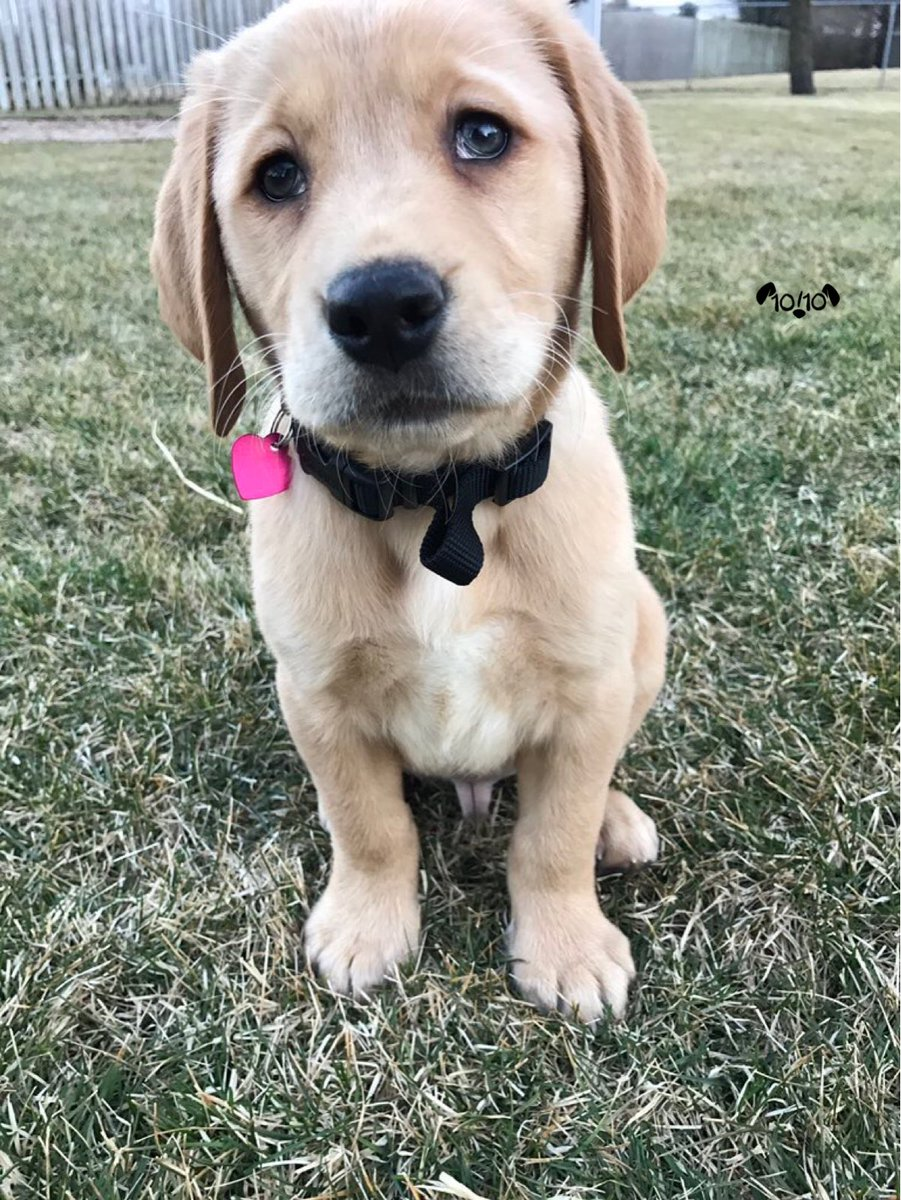

labrador_retriever 
social_total:  44908 
rating:  1.3  ( 13.0 / 10 )


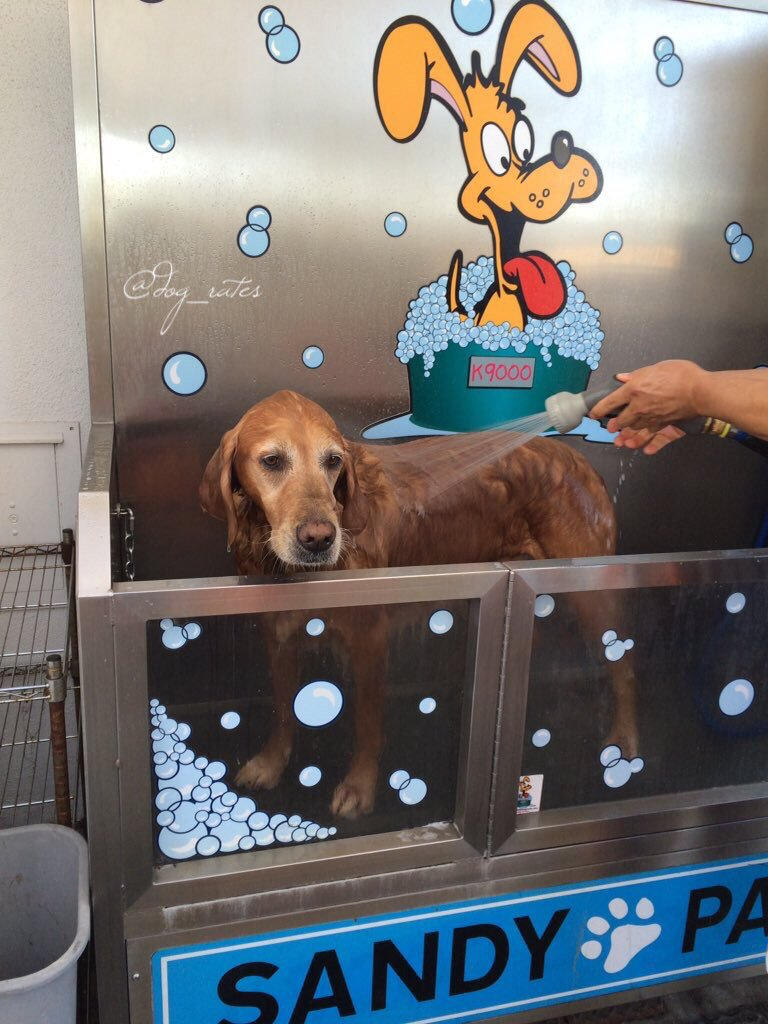

golden_retriever 
social_total:  6797 
rating:  1.0  ( 10.0 / 10 )


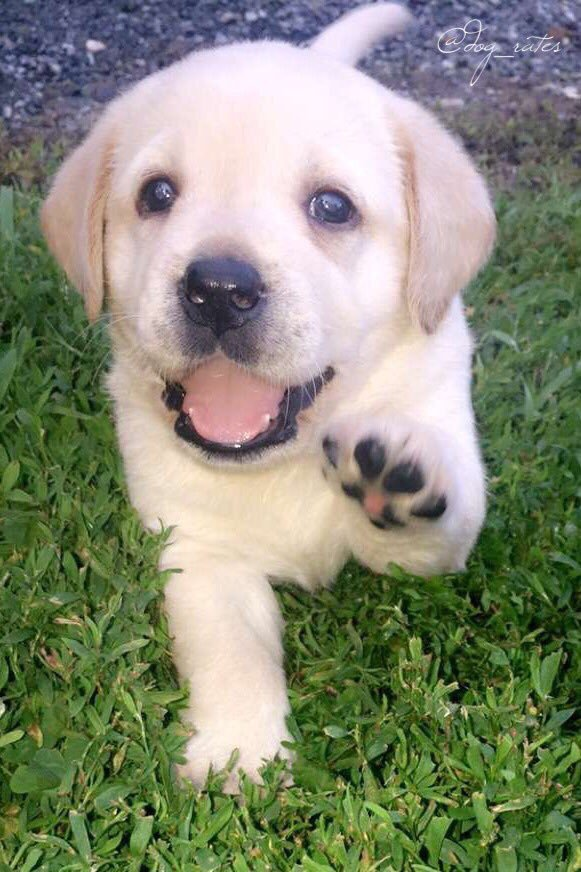

labrador_retriever 
social_total:  11481 
rating:  1.2  ( 12.0 / 10 )


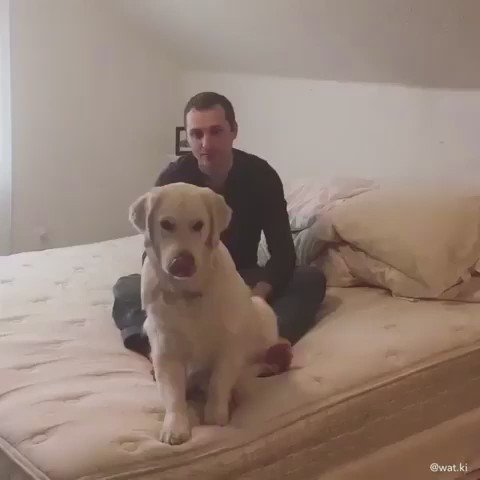

labrador_retriever 
social_total:  33902 
rating:  1.3  ( 13.0 / 10 )


In [81]:
images = df_clean.query(
    'breed == "golden_retriever" or breed == "samoyed" or \
    breed == "french_bulldog" or breed == "labrador_retriever"'
).sample(n=5)

# Display the images
for i, j in images.iterrows():
    img = Image(url=j['jpg_url'], format='jpg', width=200, embed=True)
    display(img)
    print(j['breed'], "\nsocial_total: ", j['social_total'], "\nrating: ",
          j['rating'], " (", j['rating_numerator'], "/",
          j['rating_denominator'], ")")